In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-06-16'
end_day_to_analyze = '2020-06-17'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,4597,1525,ARYA,buy,318,14.15,"{'avg': 13.9263, 'rsi': 65.83555938824752, 'ma...",2020-06-16 18:19:11.807817+00:00,2020-06-16 18:19:12.202821,13.85,14.78
1,4678,1525,ARYA,sell,318,13.80,"{'avg': 13.9357, 'rsi': [30.45759974884124, 25...",2020-06-16 19:24:54.514208+00:00,2020-06-16 19:24:54.973070,13.85,14.78
2,4517,1523,BHC,buy,409,19.25,"{'avg': 18.832, 'rsi': 64.94283628137958, 'mac...",2020-06-16 17:46:33.063539+00:00,2020-06-16 17:46:34.039948,19.03,19.75
3,4594,1523,BHC,sell,204,19.42,"{'avg': 18.8638, 'rsi': [68.7322286583969, 70....",2020-06-16 18:18:19.388600+00:00,2020-06-16 18:18:19.725679,19.03,19.75
4,4640,1523,BHC,sell,205,19.47,"{'avg': 18.8951, 'rsi': [59.03195554738997, 60...",2020-06-16 18:42:27.253827+00:00,2020-06-16 18:42:27.606090,19.03,19.75
...,...,...,...,...,...,...,...,...,...,...,...
250,4664,1524,YEXT,sell,3,16.82,"{'avg': 16.6792, 'rsi': [70.74503710654994, 71...",2020-06-16 19:04:10.442338+00:00,2020-06-16 19:04:11.007912,16.56,16.95
251,4665,1524,YEXT,sell,1,16.82,"{'avg': 16.6792, 'rsi': [70.74503710654994, 71...",2020-06-16 19:04:12.395462+00:00,2020-06-16 19:04:12.876964,16.56,16.95
252,4693,1524,YEXT,sell,2,16.66,{'liquidation': 1},2020-06-16 19:45:10.667196+00:00,2020-06-16 19:45:11.058943,16.56,16.95
253,4509,1528,YRD,buy,702,4.76,"{'avg': 4.6758, 'rsi': 62.08743554254058, 'mac...",2020-06-16 17:24:42.927631+00:00,2020-06-16 17:24:43.295465,4.63,5.05


In [7]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)
algo_runs.set_index('algo_run_id', inplace=True)

In [8]:
algo_runs

,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason,batch_id
algo_run_id,,,,,,,,
1510,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 13:51:27.150463,None,None,1e2cc6d8-2081-4387-866a-67862f5acd80
1511,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 13:51:28.781806,None,None,1e2cc6d8-2081-4387-866a-67862f5acd80
1512,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 13:51:30.583721,None,None,1e2cc6d8-2081-4387-866a-67862f5acd80
1513,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 13:51:32.349126,None,None,1e2cc6d8-2081-4387-866a-67862f5acd80
1514,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 13:51:33.939606,None,None,1e2cc6d8-2081-4387-866a-67862f5acd80
1515,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 13:51:35.470799,None,None,1e2cc6d8-2081-4387-866a-67862f5acd80
1516,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 17:15:39.708574,None,None,b677ec3d-8615-4a96-b2f3-43c6b9e04cfd
1517,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 17:17:52.403786,None,None,18b44c5b-5893-4f34-8cd4-825a561aa88e
1518,momentum_long,PAPER,v0.1-517-g0221fab,{'DSN': 'postgresql://momentum@10.63.80.3/trad...,2020-06-16 17:17:54.052518,None,None,18b44c5b-5893-4f34-8cd4-825a561aa88e


In [9]:
trade_details = {}
batch = {}
for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    batch_id = algo_runs.loc[algo_run_id]['batch_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))
    if batch_id not in batch:
        batch[batch_id] = []
    if algo_run_id not in batch[batch_id]:
        #print(batch_id, algo_run_id)
        batch[batch_id].append(algo_run_id)

In [10]:
revenues = {}
how_was_my_day = {}

for batch_id, count in batch.items():
    revenues[batch_id] = []
    symbol_name = []
    counts = []
    for run_id in batch[batch_id]:
        
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            revnue = 0
            for trade in trade_details[run_id][symbol]:
                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                revnue += delta

            revenues[batch_id].append(revnue)
            counts.append(count)
            symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[batch_id],
    }
    how_was_my_day[batch_id] = pd.DataFrame(data=d)

In [11]:
for batch_id, how_did_i_do in how_was_my_day.items():
    #display(HTML(algo_runs.loc[algo_runs['batch_id'] == batch_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[batch_id]).sum().round(2)} $ for {batch_id}')


,symbol,count,revenue
10,JFIN,2,-141.96
21,VBTX,2,-120.64
38,MIRM,2,-118.30
2,ARYA,2,-111.30
22,TOWN,2,-108.36
30,COOP,2,-108.24
19,CDXC,2,-107.69
18,CUBI,2,-106.12
7,MRNS,2,-104.00
33,HOPE,3,-103.93


TOTAL REVENUE: -1102.84 $ for eeb54190-3cc6-4d0c-b95b-8e52c3d743d2


,symbol,count,revenue
11,DCP,2,-1378.33
16,SOLO,2,-112.64
17,XERS,3,-105.00
20,KOP,4,-104.40
4,ISBC,2,-102.95
12,STAY,2,-102.60
8,CHNG,2,-102.41
13,SAN,3,-99.99
14,GOL,3,-99.84
0,FHB,3,-99.72


TOTAL REVENUE: -2836.42 $ for 1e2cc6d8-2081-4387-866a-67862f5acd80


,symbol,count,revenue
0,DCP,1,-1409.64


TOTAL REVENUE: -1409.64 $ for 18b44c5b-5893-4f34-8cd4-825a561aa88e


In [12]:
minute_history = {}
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
        for symbol, count in symbols.items():
            if symbol not in minute_history:
                minute_history[symbol] = api.polygon.historic_agg_v2(
                    symbol, 
                    1, 
                    'minute',
                    _from = str((datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date()),
                    to=str((datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date())).df


In [13]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4, minutes=1)
    #print(now)
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    #print(minute_history["close"][minute_history_index-10:minute_history_index])
    for back_track_min in range(120, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().between_time("9:30", "16:00").resample("5min").max()
        ).dropna()
        #print(series[-10:])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                #print([i for i in high_index if series[i] >= current_value])
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(120, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

SGRY analysis for run 1525 with profit -22.48


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7485.84,-7485.84,buy,2020-06-16 18:15:43.024772,13.32,"[13.14, 13.2]",[13.42],562,"{'avg': 13.3416, 'rsi': 69.39762550642716, 'macd': [0.008665073105790455, 0.010445634126844183, 0.013317063597733991, 0.017010439239054875, 0.022103420847052746], 'vwap': 13.3134, 'supports': [13.1, 13.11, 13.14, 13.16, 13.17, 13.17, 13.2, 13.2, 13.29], 'sell_macd': [0.005347083795790297, 0.006463712388958598, 0.00828882931364916, 0.010642312250892516, 0.013896424770161175], 'slow macd': [-0.0019359002955070537, -0.0011932605128084361, -0.00018822765313508683, 0.0010566078209635066, 0.002680014456156954], 'macd_signal': [0.01157847197768579, 0.011351904407517469, 0.011744936245560774, 0.012798036844259595, 0.014659113644818225], 'resistances': [13.42], 'position_ratio': '3.33', 'sell_macd_signal': [0.0075572491078147825, 0.007338541764043546, 0.007528599273964669, 0.008151341869350239, 0.009300358449512425]}",13.67,13.14
1,-3720.44,3765.40,sell,2020-06-16 18:55:29.253214,13.40,None,None,281,"{'avg': 13.3404, 'rsi': [60.56069535157732, 63.38721555890472], 'vwap': 13.4, 'reasons': 'scale-out', 'movement': 0.006006006006006011, 'sell_macd': [0.012012482640901823, 0.015161571905716542, 0.016899023645757794, 0.01699445326597626, 0.017887067862691453], 'sell_macd_signal': [0.012211725100199588, 0.012801694461302979, 0.013621160298193942, 0.014295818891750406, 0.015014068685938615]}",13.67,13.14
2,-1114.76,2605.68,sell,2020-06-16 19:45:11.795354,13.16,None,None,198,{'liquidation': 1},13.67,13.14
3,-22.48,1092.28,sell,2020-06-16 19:45:12.022252,13.16,None,None,83,{'liquidation': 1},13.67,13.14


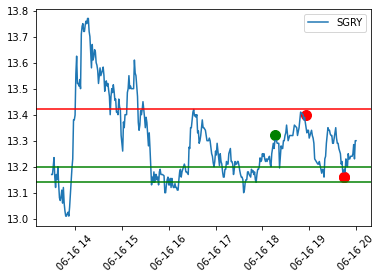

CVA analysis for run 1525 with profit -39.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7303.56,-7303.56,buy,2020-06-16 18:06:41.597957,10.06,[9.98],"[10.08, 10.08, 10.1]",726,"{'avg': 9.9855, 'rsi': 61.63014816377189, 'macd': [-0.0045203225898564625, -0.0017849657142345876, 0.00037846164660138015, 0.0028668624376066987, 0.005182653798792458], 'vwap': 10.065, 'supports': [9.89, 9.98, 10.0, 10.03, 10.035, 10.045, 10.05], 'sell_macd': [-0.0022642382569149078, -0.0004902829169459721, 0.000898387255977795, 0.002488281062722919, 0.003954584274955764], 'slow macd': [-0.0011347877525267336, -0.0007719390445402041, -0.0004368720180494279, 3.203510551230693e-05, 0.0005433614353371752], 'macd_signal': [-0.009694479342556255, -0.008112576616891921, -0.006414368964193261, -0.004558122683833269, -0.0026099673873081234], 'resistances': [10.08, 10.08, 10.1, 10.1], 'position_ratio': '1.0', 'sell_macd_signal': [-0.0057490133189043845, -0.004697267238512702, -0.003578136339614603, -0.0023648528591470987, -0.0011009654323265261]}",10.33,9.93
1,-3644.52,3659.04,sell,2020-06-16 18:15:44.136559,10.08,None,None,363,"{'avg': 9.9866, 'rsi': [63.11191448272786, 66.18043454144681], 'vwap': 10.08, 'reasons': 'scale-out', 'movement': 0.0019880715705764985, 'sell_macd': [0.0035994596769253207, 0.003757852328465816, 0.004351952416309146, 0.005277849206626328, 0.00645026424834505], 'sell_macd_signal': [0.0020794819297266986, 0.002415156009474522, 0.002802515290841447, 0.003297582073998423, 0.003928118508867749]}",10.33,9.93
2,-39.93,3604.59,sell,2020-06-16 19:15:33.494438,9.93,None,None,363,"{'avg': 9.9904, 'rsi': [35.73658786678257, 28.675477308333054], 'vwap': 9.935, 'reasons': 'stopped', 'movement': -0.014880952380952417, 'sell_macd': [-0.008581186721785983, -0.009208373906167466, -0.010356722700411325, -0.010857296790726778, -0.012924532487197382], 'sell_macd_signal': [-0.00679835188443841, -0.007280356288784221, -0.007895629571109642, -0.00848796301503307, -0.009375276909465931]}",10.33,9.93


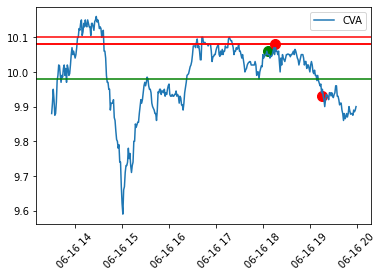

ARYA analysis for run 1525 with profit -111.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4499.7,-4499.7,buy,2020-06-16 18:19:12.202821,14.15,"[13.85, 13.935, 13.99]",[14.15],318,"{'avg': 13.9263, 'rsi': 65.83555938824752, 'macd': [0.026070343843432653, 0.035687226667482363, 0.0428151294308563, 0.04949921131747814, 0.05338219044440251], 'vwap': 14.1502, 'supports': [13.83, 13.85, 13.935, 13.9684, 13.97, 13.99, 13.99], 'sell_macd': [0.017501775528621977, 0.023611691302342308, 0.028066019290925226, 0.032206196693834954, 0.03449976094683116], 'slow macd': [-0.0018097398707617174, 0.0010430640135741243, 0.0036660666052572566, 0.00639172222182971, 0.008730853243358538], 'macd_signal': [0.009477867771611696, 0.01471973955078583, 0.020338817526799925, 0.026170896284935567, 0.03161315511682895], 'resistances': [14.35], 'position_ratio': '1.12', 'sell_macd_signal': [0.00700520089328858, 0.010326498975099326, 0.013874403038264507, 0.017540761769378597, 0.02093256160486911]}",14.78,13.85
1,-111.3,4388.4,sell,2020-06-16 19:24:54.973070,13.80,None,None,318,"{'avg': 13.9357, 'rsi': [30.45759974884124, 25.662160575741417], 'vwap': 13.8, 'reasons': 'stopped', 'movement': -0.02473498233215545, 'sell_macd': [-0.005834866515570525, -0.006638567607485157, -0.011334457190697478, -0.015308728850463638, -0.020861294704172195], 'sell_macd_signal': [-0.010431770714165407, -0.009673130092829357, -0.010005395512402981, -0.011066062180015112, -0.013025108684846529]}",14.78,13.85


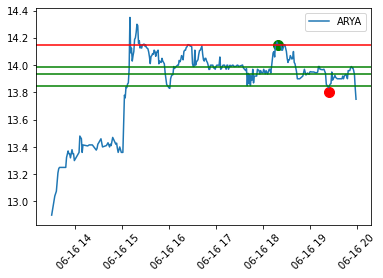

NWL analysis for run 1523 with profit 17.42


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8992.62,-8992.62,buy,2020-06-16 18:07:33.375255,15.86,"[15.76, 15.79, 15.8, 15.8]","[15.86, 15.86]",567,"{'avg': 15.6814, 'rsi': 60.303256916517114, 'macd': [0.003963914634546484, 0.006812692830340694, 0.010163585230687389, 0.011476522749697793, 0.012773251315877587], 'vwap': 15.865, 'supports': [15.645, 15.76, 15.79, 15.8, 15.8, 15.83], 'sell_macd': [0.0030478798049937694, 0.004866947869938798, 0.007000417168987028, 0.0077927254907272925, 0.008568644631164801], 'slow macd': [0.0016004966048441815, 0.0022199185825684253, 0.0030261602044845404, 0.003523184327320905, 0.00405479559054811], 'macd_signal': [-0.003742350352511943, -0.0016313417159414152, 0.0007276436733843457, 0.0028774194886470356, 0.004856585854093146], 'resistances': [15.9, 15.9, 15.94, 15.95], 'position_ratio': '1.0', 'sell_macd_signal': [-0.0020096877831328125, -0.0006343606525184902, 0.0008925949117826134, 0.0022726210275715495, 0.0035318257482902]}",16.21,15.69
1,-5133.78,3858.84,sell,2020-06-16 18:08:29.891223,15.88,None,None,243,"{'avg': 15.6817, 'rsi': [62.31230057229242, 63.3120981060054], 'vwap': 15.8802, 'reasons': 'scale-out', 'movement': 0.001261034047919379, 'sell_macd': [0.004866947869938798, 0.007000417168987028, 0.0077927254907272925, 0.00908812515064561, 0.010239240143430806], 'sell_macd_signal': [-0.0006343606525184902, 0.0008925949117826134, 0.0022726210275715495, 0.0036357218521863616, 0.00495642551043525]}",16.21,15.69
2,-5038.50,95.28,sell,2020-06-16 18:08:30.082192,15.88,None,None,6,"{'avg': 15.6817, 'rsi': [62.31230057229242, 63.3120981060054], 'vwap': 15.8802, 'reasons': 'scale-out', 'movement': 0.001261034047919379, 'sell_macd': [0.004866947869938798, 0.007000417168987028, 0.0077927254907272925, 0.00908812515064561, 0.010239240143430806], 'sell_macd_signal': [-0.0006343606525184902, 0.0008925949117826134, 0.0022726210275715495, 0.0036357218521863616, 0.00495642551043525]}",16.21,15.69
3,-4498.58,539.92,sell,2020-06-16 18:08:30.246812,15.88,None,None,34,"{'avg': 15.6817, 'rsi': [62.31230057229242, 63.3120981060054], 'vwap': 15.8802, 'reasons': 'scale-out', 'movement': 0.001261034047919379, 'sell_macd': [0.004866947869938798, 0.007000417168987028, 0.0077927254907272925, 0.00908812515064561, 0.010239240143430806], 'sell_macd_signal': [-0.0006343606525184902, 0.0008925949117826134, 0.0022726210275715495, 0.0036357218521863616, 0.00495642551043525]}",16.21,15.69
4,-2861.91,1636.67,sell,2020-06-16 18:12:26.883946,15.89,None,None,103,"{'avg': 15.6829, 'rsi': [62.31581194167496, 65.58840545159865], 'vwap': 15.895, 'reasons': 'scale-out', 'movement': 0.0009445843828714604, 'sell_macd': [0.009719759623948221, 0.010345451945692474, 0.010438907625680116, 0.01089564052403702, 0.011889255243223928], 'sell_macd_signal': [0.004852529406538734, 0.005951113914369482, 0.0068486726566316086, 0.007658066230112691, 0.008504304032734939]}",16.21,15.69
5,-2846.02,15.89,sell,2020-06-16 18:12:27.094102,15.89,None,None,1,"{'avg': 15.6829, 'rsi': [62.31581194167496, 65.58840545159865], 'vwap': 15.895, 'reasons': 'scale-out', 'movement': 0.0009445843828714604, 'sell_macd': [0.009719759623948221, 0.010345451945692474, 0.010438907625680116, 0.01089564052403702, 0.011889255243223928], 'sell_macd_signal': [0.004852529406538734, 0.005951113914369482, 0.0068486726566316086, 0.007658066230112691, 0.008504304032734939]}",16.21,15.69
6,-2798.35,47.67,sell,2020-06-16 18:12:27.289184,15.89,None,None,3,"{'avg': 15.6829, 'rsi': [62.31581194167496, 65.58840545159865], 'vwap': 15.895, 'reasons': 'scale-out', 'movement': 0.0009445843828714604, 'sell_macd': [0.009719759623948221, 0.010345451945692474, 0.010438907625680116, 0.01089564052403702, 0.011889255243223928], 'sell_macd_signal': [0.004852529406538734, 0.005951113914369482, 0.0068486726566316086, 0.007658066230112691, 0.008504304032734939]}",16.21,15.69
7,-2241.85,556.50,sell,2020-06-16 18:12:27.471585,15.90,None,None,35,"{'avg': 15.6

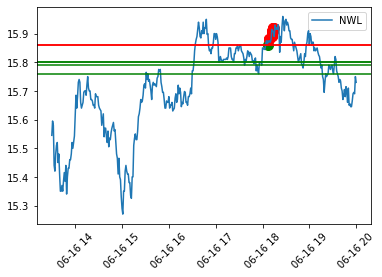

CGC analysis for run 1523 with profit 38.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10109.34,-10109.34,buy,2020-06-16 18:19:09.128363,17.46,"[17.29, 17.325, 17.3283, 17.34]","[17.555, 17.57]",579,"{'avg': 17.4222, 'rsi': 61.43020295453172, 'macd': [0.013581949909546864, 0.016955138329137753, 0.01940472881936728, 0.020305066339414424, 0.021576783013642853], 'vwap': 17.46, 'supports': [17.29, 17.325, 17.3283, 17.34, 17.3588, 17.39], 'sell_macd': [0.008764149004999666, 0.010895648807952796, 0.01241505581274538, 0.012918294312417089, 0.01366213867174082], 'slow macd': [-0.0040043529184821125, -0.0027249848062993465, -0.0015435669872871927, -0.000614092109437081, 0.00040197268959119015], 'macd_signal': [0.008820794496739311, 0.010447663263219, 0.012239076374448656, 0.013852274367441809, 0.015397176096682019], 'resistances': [17.555, 17.57], 'position_ratio': '1.36', 'sell_macd_signal': [0.00587366295681469, 0.006878060127042311, 0.007985459264182924, 0.008972026273829757, 0.00991004875341197]}",17.8,17.29
1,-5048.95,5060.39,sell,2020-06-16 18:37:13.065406,17.51,None,None,289,"{'avg': 17.4233, 'rsi': [57.17149118575586, 61.764733597686075], 'vwap': 17.51, 'reasons': 'scale-out', 'movement': 0.0028636884306987805, 'sell_macd': [0.011615697574278272, 0.010702810189201273, 0.009971952354213443, 0.010192427387288205, 0.011790298485951922], 'sell_macd_signal': [0.01059824863215489, 0.010619160943564167, 0.010489719225694022, 0.010430260858012859, 0.010702268383600671]}",17.8,17.29
2,-2507.10,2541.85,sell,2020-06-16 18:42:22.966422,17.53,None,None,145,"{'avg': 17.4237, 'rsi': [52.039675318297505, 61.32853752073015], 'vwap': 17.5335, 'reasons': 'scale-out', 'movement': 0.0013420902341518286, 'sell_macd': [0.012806825976660718, 0.012216094218668871, 0.012376353962849862, 0.010787253062691349, 0.012702404918897514], 'sell_macd_signal': [0.011040063019095468, 0.011275269259010148, 0.01149548619977809, 0.011353839572360743, 0.011623552641668098]}",17.8,17.29
3,-1243.50,1263.60,sell,2020-06-16 18:48:13.855419,17.55,None,None,72,"{'avg': 17.4243, 'rsi': [59.10994851107208, 62.23236153580768], 'vwap': 17.5426, 'reasons': 'scale-out', 'movement': 0.0011409013120364845, 'sell_macd': [0.01383271557700283, 0.013686046943895747, 0.013913499347395941, 0.013910040189770712, 0.01476565590863288], 'sell_macd_signal': [0.012523642264714826, 0.012756123200551011, 0.012987598429919997, 0.013172086781890139, 0.013490800607238687]}",17.8,17.29
4,-1190.82,52.68,sell,2020-06-16 18:50:08.197191,17.56,None,None,3,"{'avg': 17.4245, 'rsi': [60.733129021804224, 63.82599063143828], 'vwap': 17.56, 'reasons': 'scale-out', 'movement': 0.0005698005698004565, 'sell_macd': [0.013686046943895747, 0.013913499347395941, 0.013910040189770712, 0.014246175389153848, 0.015362044695304888], 'sell_macd_signal': [0.012756123200551011, 0.012987598429919997, 0.013172086781890139, 0.013386904503342881, 0.013781932541735282]}",17.8,17.29
5,-611.34,579.48,sell,2020-06-16 18:50:08.432207,17.56,None,None,33,"{'avg': 17.4245, 'rsi': [60.733129021804224, 63.82599063143828], 'vwap': 17.56, 'reasons': 'scale-out', 'movement': 0.0005698005698004565, 'sell_macd': [0.013686046943895747, 0.013913499347395941, 0.013910040189770712, 0.014246175389153848, 0.015362044695304888], 'sell_macd_signal': [0.012756123200551011, 0.012987598429919997, 0.013172086781890139, 0.013386904503342881, 0.013781932541735282]}",17.8,17.29
6,-295.26,316.08,sell,2020-06-16 18:50:09.871314,17.56,None,None,18,"{'avg': 17.4246, 'rsi': [63.82599063143828, 63.825990631438266], 'vwap': 17.56, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.013913499347395941, 0.013910040189770712, 0.014246175389153848, 0.015362044695304888, 0.01603204617159193], 'sell_macd_signal': [0.012987598429919997, 0.013172086781890139, 0.013386904503342881, 0.013781932541735282, 0.014231955267706611]}",17.8,17.29
7,-154.70,140.56,sell,2020-06-16 18:50:12.734828,17.57,None,None,8,"{'avg': 17.4247, 'rsi': [63.82599063143828, 65.2977815520

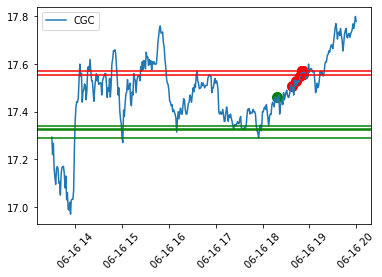

UONE analysis for run 1523 with profit 81.15


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-866.20,-866.20,buy,2020-06-16 18:03:39.380585,14.20,[12.85],[15.2001],61,"{'avg': 12.2519, 'rsi': 69.71697371151502, 'macd': [-0.011511927685505796, 0.07285876988632367, 0.12297417374019304, 0.19075149386797996, 0.24447159945108332], 'vwap': 14.2925, 'supports': [11.97, 12.405, 12.65, 12.7, 12.85, 13.07, 13.1, 13.5067], 'sell_macd': [-0.003277532528644045, 0.05145170059343229, 0.08355952249903176, 0.12697393538003077, 0.16097251768496612], 'slow macd': [-0.022875107831909602, -0.006125439902143981, 0.006255802667229915, 0.023634537549860113, 0.04014550548857798], 'macd_signal': [-0.030040205376344498, -0.009460410323810862, 0.017026506488989922, 0.05177150396478793, 0.09031152306204701], 'resistances': [15.2001], 'position_ratio': '1.13', 'sell_macd_signal': [-0.01454906875973234, -0.0013489148890994118, 0.015632772588526824, 0.037901005146827614, 0.06251530765445532]}",17.50,12.70
1,-428.80,437.40,sell,2020-06-16 18:07:12.681260,14.58,None,None,30,"{'avg': 12.2974, 'rsi': [67.47464854818475, 67.8199932457242], 'vwap': 14.4751, 'reasons': 'scale-out', 'movement': 0.021126760563380333, 'sell_macd': [0.1549984917109395, 0.15845920454397344, 0.17520184825096052, 0.20103765051288747, 0.22011700746356944], 'sell_macd_signal': [0.06132050245964999, 0.08074824287651469, 0.09963896395140386, 0.11991870126370058, 0.13995836250367436]}",17.50,12.70
2,-203.95,224.85,sell,2020-06-16 18:10:35.080287,14.99,None,None,15,"{'avg': 12.3398, 'rsi': [67.90601967624049, 72.29520071561602], 'vwap': 14.9919, 'reasons': 'scale-out', 'movement': 0.0281207133058985, 'sell_macd': [0.20103765051288747, 0.21527544902201257, 0.2216623641067592, 0.23518902048309798, 0.2634540901207245], 'sell_macd_signal': [0.11991870126370058, 0.13899005081536298, 0.1555245134736422, 0.17145741487553337, 0.1898567499245716]}",17.50,12.70
3,-81.95,122.00,sell,2020-06-16 18:19:40.724159,15.25,None,None,8,"{'avg': 12.4598, 'rsi': [60.94911296394467, 64.13106226491789], 'vwap': 15.0093, 'reasons': 'scale-out', 'movement': 0.007338225483655732, 'sell_macd': [0.19870031409237754, 0.21184810879968374, 0.20420940196382276, 0.20703366414414148, 0.22109109358147983], 'sell_macd_signal': [0.20844624832686348, 0.20912662042142754, 0.2081431767299066, 0.20792127421275358, 0.21055523808649884]}",17.50,12.70
4,-20.71,61.24,sell,2020-06-16 18:19:43.384496,15.31,None,None,4,"{'avg': 12.4619, 'rsi': [60.94911296394467, 66.1038685886696], 'vwap': 15.2476, 'reasons': 'scale-out', 'movement': 0.0032786885245902103, 'sell_macd': [0.19870031409237754, 0.21184810879968374, 0.20420940196382276, 0.20703366414414148, 0.23148070397108889], 'sell_macd_signal': [0.20844624832686348, 0.20912662042142754, 0.2081431767299066, 0.20792127421275358, 0.21263316016442063]}",17.50,12.70
5,10.09,30.80,sell,2020-06-16 18:19:44.198913,15.40,None,None,2,"{'avg': 12.4629, 'rsi': [60.94911296394467, 66.56362222017229], 'vwap': 15.3368, 'reasons': 'scale-out', 'movement': 0.002612671456564281, 'sell_macd': [0.19870031409237754, 0.21184810879968374, 0.20420940196382276, 0.20703366414414148, 0.23407810656849293], 'sell_macd_signal': [0.20844624832686348, 0.20912662042142754, 0.2081431767299066, 0.20792127421275358, 0.21315264068390144]}",17.50,12.70
6,25.49,15.40,sell,2020-06-16 18:19:46.071800,15.40,None,None,1,"{'avg': 12.464, 'rsi': [60.94911296394467, 66.33531502810064], 'vwap': 15.3516, 'reasons': 'scale-out', 'movement': -0.004870129870129939, 'sell_macd': [0.19870031409237754, 0.21184810879968374, 0.20420940196382276, 0.20703366414414148, 0.23277940526979002], 'sell_macd_signal': [0.20844624832686348, 0.20912662042142754, 0.2081431767299066, 0.20792127421275358, 0.21289290042416087]}",17.50,12.70
7,40.85,15.36,sell,2020-06-16 18:23:42.520843,15.36,None,None,1,"{'avg': 12.5189, 'rsi': [58.76700204352677, 62.84082525030018], 'vwap': 15.3163, 'reasons': 'scale-out', 'movement': -0.0045454545454545634, 'sell_macd': [0.235459

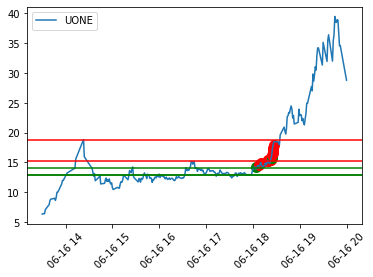

BHC analysis for run 1523 with profit 79.78


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7873.25,-7873.25,buy,2020-06-16 17:46:34.039948,19.25,[19.08],[19.254],409,"{'avg': 18.832, 'rsi': 64.94283628137958, 'macd': [0.013176811555251078, 0.018568358306339405, 0.02178317860071388, 0.024851391895726493, 0.029365218358819334], 'vwap': 19.2645, 'supports': [18.32, 18.36, 18.42, 18.97, 19.08], 'sell_macd': [0.005554984447353917, 0.009224454896969547, 0.011444503885023494, 0.013545262786298196, 0.016564746829025978], 'slow macd': [0.0630929658436159, 0.06304978236860492, 0.06274927684862064, 0.06253237948401846, 0.06271262324495908], 'macd_signal': [0.013048264674644067, 0.014152283400983134, 0.015678462440929283, 0.017513048331888725, 0.019883482337274848], 'resistances': [19.595, 19.63], 'position_ratio': '1.71', 'sell_macd_signal': [0.004700753019246986, 0.0056054933947914986, 0.006773295492837898, 0.008127688951529956, 0.00981510052702916]}",19.75,19.03
1,-3911.57,3961.68,sell,2020-06-16 18:18:19.725679,19.42,None,None,204,"{'avg': 18.8638, 'rsi': [68.7322286583969, 70.79444447821784], 'vwap': 19.425, 'reasons': 'scale-out', 'movement': 0.009090909090909129, 'sell_macd': [0.027365483782133992, 0.02756591567094091, 0.029442019536624287, 0.03026181450291432, 0.03154656623635077], 'sell_macd_signal': [0.021894018806042092, 0.023028398179021855, 0.02431112245054234, 0.025501260861016735, 0.026710321936083543]}",19.75,19.03
2,79.78,3991.35,sell,2020-06-16 18:42:27.606090,19.47,None,None,205,"{'avg': 18.8951, 'rsi': [59.03195554738997, 60.368594395427436], 'vwap': 19.47, 'reasons': 'bail', 'movement': 0.002574665293511697, 'sell_macd': [0.022628349387506574, 0.02318805060466289, 0.022284076869915737, 0.021290278156218534, 0.02075887294871137], 'sell_macd_signal': [0.019722724976682097, 0.020415790102278255, 0.02078944745580575, 0.020889613595888305, 0.02086346546645292]}",19.75,19.03


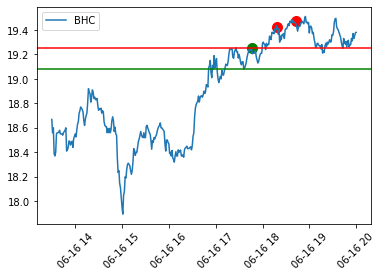

MRNS analysis for run 1523 with profit -104.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3757.0,-3757.0,buy,2020-06-16 18:22:53.934155,2.89,"[2.815, 2.845, 2.875]",[2.89],1300,"{'avg': 2.9771, 'rsi': 63.65858667167173, 'macd': [0.0037125644498074983, 0.0037763189141246656, 0.004979815216206607, 0.005865975393436695, 0.0065412749580078255], 'vwap': 2.8956, 'supports': [2.78, 2.81, 2.815, 2.845, 2.875], 'sell_macd': [0.0022021441877178027, 0.0022337475428448883, 0.003008584604724973, 0.0035732812165183425, 0.003998067131986804], 'slow macd': [0.0028245654029763756, 0.002902825997696201, 0.0032100896220303987, 0.003487647895163093, 0.0037470285408640613], 'macd_signal': [0.004604781734021458, 0.0044390891700420996, 0.004547234379275001, 0.00481098258210734, 0.005157041057287437], 'resistances': [2.9361], 'position_ratio': '1.97', 'sell_macd_signal': [0.002863840443036025, 0.0027378218629977974, 0.0027919744113432325, 0.0029482357723782547, 0.0031582020442999644]}",3.05,2.82
1,-104.0,3653.0,sell,2020-06-16 19:10:41.966232,2.81,None,None,1300,"{'avg': 2.9738, 'rsi': [38.8989826633847, 24.387609228384974], 'vwap': 2.8193, 'reasons': 'stopped', 'movement': -0.027681660899654004, 'sell_macd': [-0.004879988801623103, -0.0047575036129710035, -0.004382093029437151, -0.004453434223703923, -0.006529110034513064], 'sell_macd_signal': [-0.004461009296478385, -0.004520308159776909, -0.004492665133708958, -0.004484818951707951, -0.004893677168268973]}",3.05,2.82


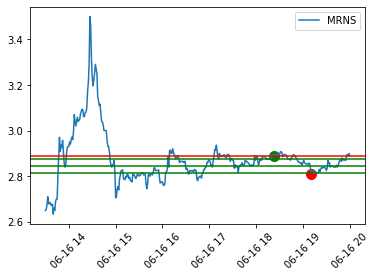

X analysis for run 1523 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3678.48,-3678.48,buy,2020-06-16 18:17:06.285782,10.48,"[10.253, 10.3337]",[10.48],351,"{'avg': 10.4228, 'rsi': 69.52230118170132, 'macd': [0.02721545660180169, 0.030707628859410363, 0.031498275171104595, 0.0333621915102249, 0.03445828332565881], 'vwap': 10.4809, 'supports': [10.253, 10.3337, 10.35, 10.4426], 'sell_macd': [0.017940975334109766, 0.02005734831742423, 0.020407024040558497, 0.021458628187929207, 0.02200976611850436], 'slow macd': [-0.0018866178009435686, -0.00018552511206060274, 0.0010599592452233964, 0.0025256208482336007, 0.0038732357483279856], 'macd_signal': [0.017506195044679363, 0.020146481807625564, 0.02241684048032137, 0.024605910686302076, 0.026576385214173423], 'resistances': [10.515], 'position_ratio': '0.92', 'sell_macd_signal': [0.012112848424746326, 0.013701748403281906, 0.015042803530737224, 0.01632596846217562, 0.017462727993441368]}",11.04,10.2
1,0.00,3678.48,sell,2020-06-16 18:40:08.897266,10.48,None,None,351,"{'avg': 10.4212, 'rsi': [59.20433548548495, 60.44208882695427], 'vwap': 10.49, 'reasons': 'bail', 'movement': 0.0009541984732824223, 'sell_macd': [0.011384576248966383, 0.011235172531026905, 0.01071310245820456, 0.010426903668236065, 0.010328217550490848], 'sell_macd_signal': [0.010338834269779388, 0.010518101922028891, 0.010557102029264024, 0.010531062357058432, 0.010490493395744916]}",11.04,10.2


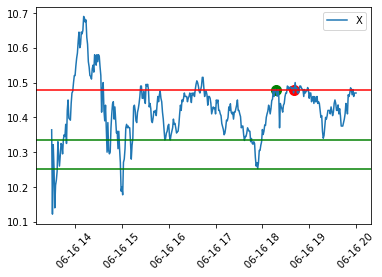

MARK analysis for run 1523 with profit -30.08


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1045.28,-1045.28,buy,2020-06-16 18:04:05.242751,2.78,"[2.5877, 2.6546]",[2.909],376,"{'avg': 2.5887, 'rsi': 64.5031019881365, 'macd': [0.01579964669381928, 0.016812659412348996, 0.019034106306782483, 0.025343968046788845, 0.030812446982158015], 'vwap': 2.7884, 'supports': [2.21, 2.21, 2.225, 2.5877, 2.6546], 'sell_macd': [0.006119130731025546, 0.006995136094485321, 0.008641437207642877, 0.012928925903510358, 0.016631788187257524], 'slow macd': [0.058144284456171036, 0.057549959964905195, 0.05723578943541208, 0.05781481800554156, 0.05841821083554821], 'macd_signal': [0.020197618337915883, 0.019520626552802504, 0.0194233225035985, 0.02060745161223657, 0.02264845068622086], 'resistances': [2.909], 'position_ratio': '0.88', 'sell_macd_signal': [0.008085705495386241, 0.007867591615206056, 0.008022360733693421, 0.009003673767656808, 0.010529296651576951]}",3.31,2.53
1,-30.08,1015.20,sell,2020-06-16 19:45:06.999531,2.70,None,None,376,{'liquidation': 1},3.31,2.53


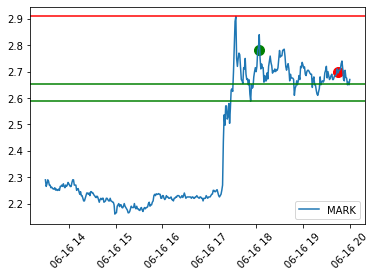

JFIN analysis for run 1523 with profit -141.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1728.09,-1728.09,buy,2020-06-16 17:34:47.032327,6.33,"[5.8799, 6.02]",[6.39],273,"{'avg': 5.795, 'rsi': 63.01707488914129, 'macd': [0.06553268094400622, 0.0681244990968004, 0.0678631087709638, 0.07087355100831694, 0.07880625018563592], 'vwap': 6.3296, 'supports': [5.3513, 5.4, 5.552, 5.61, 5.8799, 6.02], 'sell_macd': [0.03477955340104888, 0.0366041316857082, 0.03656348967783618, 0.03865437266289895, 0.043937471447845766], 'slow macd': [0.08788217264124665, 0.08879242834778367, 0.08918400318478881, 0.09020130733801146, 0.09227248351842476], 'macd_signal': [0.08586893867477079, 0.08232005075917671, 0.07942866236153413, 0.07771764009089069, 0.07793536210983973], 'resistances': [7.0], 'position_ratio': '2.16', 'sell_macd_signal': [0.04806226826343112, 0.045770640947886534, 0.043929210693876466, 0.042874243087680966, 0.04308688875971393]}",7.05,5.97
1,-141.96,1586.13,sell,2020-06-16 17:55:10.034654,5.81,None,None,273,"{'avg': 5.8589, 'rsi': [40.406439972980365, 31.753901652817923], 'vwap': 5.9214, 'reasons': 'stopped', 'movement': -0.08056872037914689, 'sell_macd': [-0.0029325908357291652, -0.005571204713413103, -0.008079589491954309, -0.015638336209104153, -0.032234264349622066], 'sell_macd_signal': [0.01736131452652867, 0.012774810678540315, 0.00860393064444139, 0.003755477273732281, -0.0034424710509385883]}",7.05,5.97


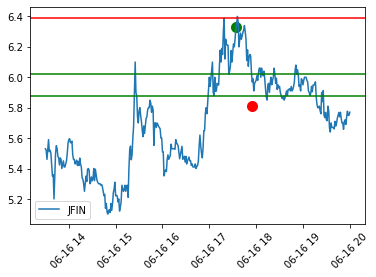

QIWI analysis for run 1527 with profit 48.03


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9052.80,-9052.80,buy,2020-06-16 17:22:46.148358,14.72,"[14.62, 14.63]",[14.8],615,"{'avg': 14.5507, 'rsi': 58.49262851958619, 'macd': [-0.004522094013287514, -0.0024772589062767025, -4.92284502833229e-05, 0.0010559148237874183, 0.005100617789812745], 'vwap': 14.72, 'supports': [14.29, 14.39, 14.46, 14.46, 14.46, 14.47, 14.55, 14.62, 14.62, 14.63], 'sell_macd': [-0.004382234912212013, -0.0029230519227603224, -0.0012285839839289991, -0.00041174423959589035, 0.0023080236681920496], 'slow macd': [0.024368180985550936, 0.02402345160102115, 0.023827803412212134, 0.023449755552917395, 0.023704178924988994], 'macd_signal': [0.0009668272000432673, 0.0002780099787792732, 0.00021256229296675395, 0.0003812327991308868, 0.0013251097972672584], 'resistances': [14.8], 'position_ratio': '0.89', 'sell_macd_signal': [-0.0013271121323268934, -0.0016463000904135792, -0.0015627568691166632, -0.0013325543432125087, -0.000604438740931597]}",15.04,14.56
1,-4515.34,4537.46,sell,2020-06-16 18:12:12.305308,14.78,None,None,307,"{'avg': 14.5645, 'rsi': [59.49728531808455, 62.5431223017613], 'vwap': 14.78, 'reasons': 'scale-out', 'movement': 0.004076086956521652, 'sell_macd': [0.009602515396238687, 0.010419917429802084, 0.011441010995829615, 0.012088083761618407, 0.01347426924455064], 'sell_macd_signal': [0.005451216936365498, 0.006444957035052815, 0.007444167827208175, 0.008372951014090222, 0.009393214660182305]}",15.04,14.56
2,-2236.14,2279.20,sell,2020-06-16 18:12:24.899883,14.80,None,None,154,"{'avg': 14.5679, 'rsi': [62.5431223017613, 65.34932420938169], 'vwap': 14.7929, 'reasons': 'scale-out', 'movement': 0.001353179972936492, 'sell_macd': [0.010419917429802084, 0.011441010995829615, 0.012088083761618407, 0.01347426924455064, 0.015418384305995403], 'sell_macd_signal': [0.006444957035052815, 0.007444167827208175, 0.008372951014090222, 0.009393214660182305, 0.010598248589344925]}",15.04,14.56
3,-1095.00,1141.14,sell,2020-06-16 18:12:54.094918,14.82,None,None,77,"{'avg': 14.5689, 'rsi': [62.5431223017613, 67.76436035306034], 'vwap': 14.82, 'reasons': 'scale-out', 'movement': 0.0013513513513513226, 'sell_macd': [0.010419917429802084, 0.011441010995829615, 0.012088083761618407, 0.01347426924455064, 0.01645734534495702], 'sell_macd_signal': [0.006444957035052815, 0.007444167827208175, 0.008372951014090222, 0.009393214660182305, 0.010806040797137248]}",15.04,14.56
4,-531.08,563.92,sell,2020-06-16 18:14:20.422246,14.84,None,None,38,"{'avg': 14.5798, 'rsi': [68.4884359264408, 68.4884359264408], 'vwap': 14.8325, 'reasons': 'scale-out', 'movement': 0.00134952766531711, 'sell_macd': [0.012088083761618407, 0.01347426924455064, 0.018015786903399444, 0.020801180054405677, 0.02270147108045606], 'sell_macd_signal': [0.008372951014090222, 0.009393214660182305, 0.011117729108825733, 0.013054419297941721, 0.01498382965444459]}",15.04,14.56
5,-249.12,281.96,sell,2020-06-16 18:14:23.808124,14.84,None,None,19,"{'avg': 14.5805, 'rsi': [68.4884359264408, 68.4884359264408], 'vwap': 14.84, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.012088083761618407, 0.01347426924455064, 0.018015786903399444, 0.020801180054405677, 0.02270147108045606], 'sell_macd_signal': [0.008372951014090222, 0.009393214660182305, 0.011117729108825733, 0.013054419297941721, 0.01498382965444459]}",15.04,14.56
6,-100.52,148.60,sell,2020-06-16 18:17:36.527351,14.86,None,None,10,"{'avg': 14.5812, 'rsi': [71.65228419005855, 66.72515302915258], 'vwap': 14.85, 'reasons': 'scale-out', 'movement': 0.0006738544474393387, 'sell_macd': [0.018015786903399444, 0.020801180054405677, 0.023220951599938644, 0.025843878108146257, 0.026513121126123806], 'sell_macd_signal': [0.011117729108825733, 0.013054419297941721, 0.015087725758341105, 0.017238956228302134, 0.019093789207866467]}",15.04,14.56
7,-26.17,74.35,sell,2020-06-16 18:17:40.899743,14.87,None,None,5,"{'avg': 14.5826, 'rsi': [71.65228419005855, 71.65228419005855

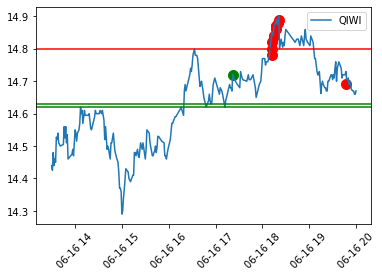

SPTN analysis for run 1527 with profit 35.63


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7213.86,-7213.86,buy,2020-06-16 18:15:30.223823,19.71,"[19.58, 19.6]","[19.74, 19.79]",366,"{'avg': 19.4232, 'rsi': 59.62835065585427, 'macd': [0.0037237845596465036, 0.005693668394929574, 0.00876758116166343, 0.01187372271780518, 0.014171996327682734], 'vwap': 19.7069, 'supports': [19.44, 19.44, 19.47, 19.58, 19.58, 19.6, 19.68], 'sell_macd': [0.0019173983705051967, 0.003240688676072523, 0.005268698152150364, 0.007300021144519775, 0.008788064760075542], 'slow macd': [0.01833562893177998, 0.018364959122564528, 0.018682443701731444, 0.019104595737662322, 0.019462433983054694], 'macd_signal': [-0.0028428203610626644, -0.0011355226098642163, 0.0008450981444413129, 0.0030508230591140867, 0.005275057712827816], 'resistances': [19.74, 19.79], 'position_ratio': '1.0', 'sell_macd_signal': [-0.002757921297570424, -0.0015581993028418346, -0.00019281981184339492, 0.0013057483794292391, 0.0028022116555585]}",20.07,19.53
1,-10761.66,-3547.80,buy,2020-06-16 18:15:30.491278,19.71,"[19.58, 19.6]","[19.74, 19.79]",180,"{'avg': 19.4232, 'rsi': 59.62835065585427, 'macd': [0.0037237845596465036, 0.005693668394929574, 0.00876758116166343, 0.01187372271780518, 0.014171996327682734], 'vwap': 19.7069, 'supports': [19.44, 19.44, 19.47, 19.58, 19.58, 19.6, 19.68], 'sell_macd': [0.0019173983705051967, 0.003240688676072523, 0.005268698152150364, 0.007300021144519775, 0.008788064760075542], 'slow macd': [0.01833562893177998, 0.018364959122564528, 0.018682443701731444, 0.019104595737662322, 0.019462433983054694], 'macd_signal': [-0.0028428203610626644, -0.0011355226098642163, 0.0008450981444413129, 0.0030508230591140867, 0.005275057712827816], 'resistances': [19.74, 19.79], 'position_ratio': '1.0', 'sell_macd_signal': [-0.002757921297570424, -0.0015581993028418346, -0.00019281981184339492, 0.0013057483794292391, 0.0028022116555585]}",20.07,19.53
2,-5364.45,5397.21,sell,2020-06-16 18:19:25.952579,19.77,None,None,273,"{'avg': 19.4336, 'rsi': [59.49695886903632, 66.01678774199672], 'vwap': 19.7501, 'reasons': 'scale-out', 'movement': 0.003044140030441335, 'sell_macd': [0.009307545279554574, 0.009192531030496554, 0.009503006537325831, 0.010660480873330158, 0.014021363721212765], 'sell_macd_signal': [0.0029061077594543065, 0.004163392413662756, 0.005231315238395371, 0.006317148365382328, 0.007857991436548415]}",20.07,19.53
3,-2675.73,2688.72,sell,2020-06-16 18:20:21.780706,19.77,None,None,136,"{'avg': 19.4351, 'rsi': [59.49695886903632, 66.01678774199672], 'vwap': 19.77, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.009307545279554574, 0.009192531030496554, 0.009503006537325831, 0.010660480873330158, 0.014021363721212765], 'sell_macd_signal': [0.0029061077594543065, 0.004163392413662756, 0.005231315238395371, 0.006317148365382328, 0.007857991436548415]}",20.07,19.53
4,-1329.33,1346.40,sell,2020-06-16 18:39:56.936323,19.80,None,None,68,"{'avg': 19.4524, 'rsi': [62.113522468832784, 65.26713256388622], 'vwap': 19.7886, 'reasons': 'scale-out', 'movement': 0.0010116337885685165, 'sell_macd': [0.012462424159146224, 0.011928373069579834, 0.01135731542745333, 0.012323279402064458, 0.01395489705238262], 'sell_macd_signal': [0.011372577026288449, 0.011483736234946727, 0.011458452073448047, 0.011631417539171329, 0.012096113441813588]}",20.07,19.53
5,-1032.33,297.00,sell,2020-06-16 18:45:02.723299,19.80,None,None,15,"{'avg': 19.4575, 'rsi': [58.31359230081905, 59.897994974006764], 'vwap': 19.8, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.016495225430603, 0.01764038566524917, 0.019342583436849026, 0.01833984685060841, 0.01783979435677452], 'sell_macd_signal': [0.013614000255115985, 0.014419277337142622, 0.015403938557083902, 0.015991120215788805, 0.016360855043985947]}",20.07,19.53
6,-656.13,376.20,sell,2020-06-16 18:45:51.483442,19.80,None,None,19,"{'avg': 19.4575, 'rsi': [58.31359230081905, 59.897994974006764], 'vwap': 19.8, 'reasons': 'scale-out', 'moveme

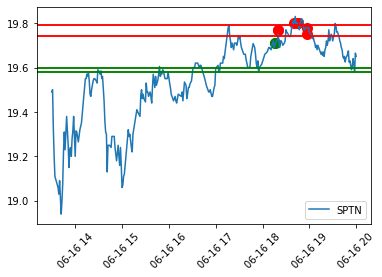

PERI analysis for run 1527 with profit -98.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5591.7,-5591.7,buy,2020-06-16 18:11:10.525478,5.7,"[5.51, 5.51, 5.5919, 5.63, 5.63, 5.65, 5.65]","[5.78, 5.78]",981,"{'avg': 5.5312, 'rsi': 68.32428827679638, 'macd': [0.009192315395500472, 0.009554440465969094, 0.010367450815014223, 0.011045821307114956, 0.013046871449848396], 'vwap': 5.6969, 'supports': [5.3115, 5.4, 5.4027, 5.41, 5.51, 5.51, 5.51, 5.52, 5.525, 5.5919, 5.63, 5.63, 5.65, 5.65], 'sell_macd': [0.00450026171405149, 0.004786424996728655, 0.005362832424831154, 0.005846229999654007, 0.0071859394086111195], 'slow macd': [0.02273914874088323, 0.022596816643035034, 0.02255767493023253, 0.02251757265878851, 0.022764535626710547], 'macd_signal': [0.012174506216411142, 0.011650493066322733, 0.011393884616061032, 0.011324271954271816, 0.011668791853387133], 'resistances': [5.78, 5.78], 'position_ratio': '1.6', 'sell_macd_signal': [0.006272831773871214, 0.005975550418442702, 0.005853006819720392, 0.0058516514557071155, 0.0061185090462879165]}",5.9,5.6
1,-1918.1,3673.6,sell,2020-06-16 19:41:24.114922,5.6,None,None,656,"{'avg': 5.5503, 'rsi': [33.372268843840985, 28.682940562899727], 'vwap': 5.6, 'reasons': 'stopped', 'movement': -0.0175438596491229, 'sell_macd': [-0.0043838935993019135, -0.004915720000017387, -0.005287068883691681, -0.005507768417936099, -0.006127693140490997], 'sell_macd_signal': [-0.0046656842313476145, -0.004715691385081569, -0.004829966884803591, -0.004965527191430093, -0.005197960381242274]}",5.9,5.6
2,-1173.3,744.8,sell,2020-06-16 19:41:24.339453,5.6,None,None,133,"{'avg': 5.5503, 'rsi': [33.372268843840985, 28.682940562899727], 'vwap': 5.6, 'reasons': 'stopped', 'movement': -0.0175438596491229, 'sell_macd': [-0.0043838935993019135, -0.004915720000017387, -0.005287068883691681, -0.005507768417936099, -0.006127693140490997], 'sell_macd_signal': [-0.0046656842313476145, -0.004715691385081569, -0.004829966884803591, -0.004965527191430093, -0.005197960381242274]}",5.9,5.6
3,-98.1,1075.2,sell,2020-06-16 19:41:24.564627,5.6,None,None,192,"{'avg': 5.5503, 'rsi': [33.372268843840985, 28.682940562899727], 'vwap': 5.6, 'reasons': 'stopped', 'movement': -0.0175438596491229, 'sell_macd': [-0.0043838935993019135, -0.004915720000017387, -0.005287068883691681, -0.005507768417936099, -0.006127693140490997], 'sell_macd_signal': [-0.0046656842313476145, -0.004715691385081569, -0.004829966884803591, -0.004965527191430093, -0.005197960381242274]}",5.9,5.6


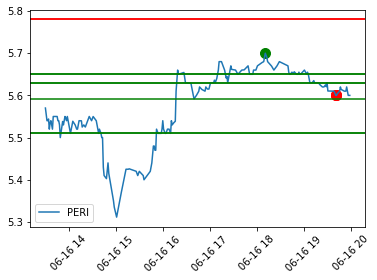

BXC analysis for run 1527 with profit 38.61


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6030.18,-6030.18,buy,2020-06-16 17:48:22.520386,8.59,"[8.43, 8.52, 8.535]",[8.63],702,"{'avg': 8.4291, 'rsi': 58.16289382541394, 'macd': [0.00801828134176752, 0.005817298913761704, 0.0068186112688710665, 0.007525410279068723, 0.011184293716926419], 'vwap': 8.61, 'supports': [8.15, 8.3, 8.3725, 8.4258, 8.43, 8.46, 8.52, 8.535, 8.6], 'sell_macd': [0.0054780248920192065, 0.003989414094244026, 0.004595828873974028, 0.005008673781894402, 0.00734324547920906], 'slow macd': [0.02174622374716151, 0.020923178677115573, 0.02069226327492224, 0.020446719335080132, 0.020827853488251336], 'macd_signal': [0.004522866057587442, 0.004781752628822295, 0.005189124356832049, 0.0056563815412793835, 0.006761963976408791], 'resistances': [8.63, 8.65, 8.65, 8.725], 'position_ratio': '2.0', 'sell_macd_signal': [0.0032820533926124565, 0.0034235255329387706, 0.003657986201145822, 0.003928123717295538, 0.004611148069678242]}",8.89,8.47
1,-2994.03,3036.15,sell,2020-06-16 18:05:29.953231,8.65,None,None,351,"{'avg': 8.4326, 'rsi': [60.59044385246677, 59.00319780947709], 'vwap': 8.6475, 'reasons': 'scale-out', 'movement': 0.005820721769499501, 'sell_macd': [0.010538851424328755, 0.009635785015198906, 0.008287476319573273, 0.011285060760391374, 0.012954801094011259], 'sell_macd_signal': [0.006979639438770575, 0.0075108685540562405, 0.007666190107159647, 0.008389964237805993, 0.009302931609047046]}",8.89,8.47
2,38.61,3032.64,sell,2020-06-16 18:18:32.985317,8.64,None,None,351,"{'avg': 8.4408, 'rsi': [55.622947026289694, 57.39533670456366], 'vwap': 8.65, 'reasons': 'bail', 'movement': 0.0, 'sell_macd': [0.014968727683392302, 0.014167852712272833, 0.013879276725527134, 0.012954681453704708, 0.012585455508729027], 'sell_macd_signal': [0.013731790302401879, 0.01381900278437607, 0.013831057572606283, 0.013655782348825968, 0.01344171698080658]}",8.89,8.47


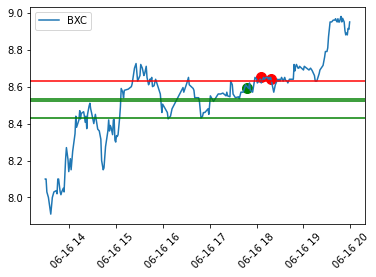

XFOR analysis for run 1528 with profit 32.02


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4861.60,-4861.60,buy,2020-06-16 18:23:05.648359,9.44,"[9.1633, 9.1901, 9.21, 9.2201, 9.27, 9.3, 9.32, 9.4201]","[9.49, 9.55, 9.57, 9.58, 9.78]",515,"{'avg': 9.3831, 'rsi': 56.38350588688164, 'macd': [-0.02689007148509326, -0.020377208070801345, -0.009250865417772758, 0.0017495553550297416, 0.0071572974949187795], 'vwap': 9.4251, 'supports': [8.58, 8.608, 8.61, 8.64, 8.755, 9.1633, 9.1901, 9.21, 9.2201, 9.27, 9.28, 9.3, 9.32, 9.4201], 'sell_macd': [-0.01596119995812373, -0.011627348005012195, -0.004327887418106968, 0.0028343920966005243, 0.006300656756156542], 'slow macd': [0.022317671487405377, 0.02188421158189513, 0.02261154941120047, 0.023681184816073397, 0.023987664755036775], 'macd_signal': [-0.03836286303744321, -0.03476573204411484, -0.02966275871884642, -0.02338029590407119, -0.017272777224273193], 'resistances': [9.48, 9.49, 9.55, 9.57, 9.58, 9.78], 'position_ratio': '2.01', 'sell_macd_signal': [-0.024312088899612068, -0.021775140720692095, -0.01828569006017507, -0.014061673628819951, -0.009989207551824652]}",9.82,9.25
1,-2420.10,2441.50,sell,2020-06-16 19:06:14.077663,9.50,None,None,257,"{'avg': 9.3877, 'rsi': [62.41941731757843, 62.430231723017684], 'vwap': 9.5043, 'reasons': 'scale-out', 'movement': 0.0063665254237288416, 'sell_macd': [0.011615198682765282, 0.013157891857821014, 0.01626703080127001, 0.018478476331214466, 0.019966895233363147], 'sell_macd_signal': [0.006268666949376605, 0.007646511931065487, 0.009370615705106392, 0.011192187830328007, 0.012947129310935035]}",9.82,9.25
2,-2144.60,275.50,sell,2020-06-16 19:06:32.742735,9.50,None,None,29,"{'avg': 9.3886, 'rsi': [62.41941731757843, 62.41941731757844], 'vwap': 9.5, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.011615198682765282, 0.013157891857821014, 0.01626703080127001, 0.018478476331214466, 0.01996170042816736], 'sell_macd_signal': [0.006268666949376605, 0.007646511931065487, 0.009370615705106392, 0.011192187830328007, 0.012946090349895878]}",9.82,9.25
3,-1194.60,950.00,sell,2020-06-16 19:06:32.990740,9.50,None,None,100,"{'avg': 9.3886, 'rsi': [62.41941731757843, 62.41941731757844], 'vwap': 9.5, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.011615198682765282, 0.013157891857821014, 0.01626703080127001, 0.018478476331214466, 0.01996170042816736], 'sell_macd_signal': [0.006268666949376605, 0.007646511931065487, 0.009370615705106392, 0.011192187830328007, 0.012946090349895878]}",9.82,9.25
4,-587.24,607.36,sell,2020-06-16 19:26:51.237788,9.49,None,None,64,"{'avg': 9.3934, 'rsi': [61.27572310109858, 59.30469068905592], 'vwap': 9.4917, 'reasons': 'scale-out', 'movement': -0.0008736842105263364, 'sell_macd': [0.020680471504682885, 0.020903023748466865, 0.020804973240396762, 0.020458375789425887, 0.01949143783036611], 'sell_macd_signal': [0.015494640429367998, 0.01657631709318777, 0.017422048322629568, 0.01802931381598883, 0.018321738618864287]}",9.82,9.25
5,-282.28,304.96,sell,2020-06-16 19:30:09.357256,9.53,None,None,32,"{'avg': 9.3947, 'rsi': [59.30469068905592, 64.91327796368523], 'vwap': 9.53, 'reasons': 'scale-out', 'movement': 0.0042149631190726185, 'sell_macd': [0.020903023748466865, 0.020804973240396762, 0.020458375789425887, 0.01949143783036611, 0.020474454513822238], 'sell_macd_signal': [0.01657631709318777, 0.017422048322629568, 0.01802931381598883, 0.018321738618864287, 0.018752281797855878]}",9.82,9.25
6,-129.80,152.48,sell,2020-06-16 19:42:49.424453,9.53,None,None,16,"{'avg': 9.4016, 'rsi': [65.57707167967696, 60.50826391681004], 'vwap': 9.53, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.0199355784942572, 0.021334693563503038, 0.02214783915559515, 0.022493824822737096, 0.021432335409825143], 'sell_macd_signal': [0.01898894113713614, 0.01945809162240952, 0.019996041129046647, 0.020495597867784737, 0.020682945376192818]}",9.82,9.25
7,-53.48,76.32,sell,2020-06-16 19:42:53.114090,9.54,None,None,8,"{'avg': 9.4021, 'rsi': [65

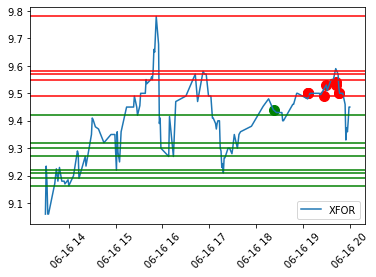

RUBY analysis for run 1528 with profit 38.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6733.55,-6733.55,buy,2020-06-16 17:43:14.594846,6.85,"[6.66, 6.7025, 6.75, 6.8, 6.8, 6.805, 6.815]",[6.88],983,"{'avg': 6.7582, 'rsi': 61.01646983975052, 'macd': [0.008035455369013178, 0.007880228482714635, 0.00926425039820522, 0.011040743347399129, 0.012306762115600556], 'vwap': 6.85, 'supports': [6.35, 6.405, 6.49, 6.6001, 6.66, 6.7, 6.7025, 6.72, 6.75, 6.8, 6.8, 6.805, 6.815], 'sell_macd': [0.003796869628802213, 0.0037474193177633452, 0.004699179863476566, 0.0058992636671035825, 0.006757780089837517], 'slow macd': [0.025798555085698283, 0.025408935800476762, 0.0253297076043566, 0.025376239827591185, 0.025378465211978174], 'macd_signal': [0.011529118211265368, 0.010799340265555221, 0.01049232229208522, 0.010602006503148003, 0.010942957625638513], 'resistances': [6.88], 'position_ratio': '0.86', 'sell_macd_signal': [0.005917438779776909, 0.005483434887374196, 0.00532658388259467, 0.005441119839496453, 0.005704451889564666]}",7.05,6.75
1,-3350.56,3382.99,sell,2020-06-16 18:00:58.278595,6.89,None,None,491,"{'avg': 6.7732, 'rsi': [64.3507482672532, 63.504049617980904], 'vwap': 6.8982, 'reasons': 'scale-out', 'movement': 0.005839416058394166, 'sell_macd': [0.003292249088839405, 0.0049814714388851655, 0.008310976238415257, 0.010433824442745099, 0.011796643505304516], 'sell_macd_signal': [0.005052342294531068, 0.005038168123401888, 0.005692729746404562, 0.0066409486856726695, 0.007672087649599039]}",7.05,6.75
2,-1655.62,1694.94,sell,2020-06-16 18:09:31.987266,6.89,None,None,246,"{'avg': 6.7752, 'rsi': [57.296123017181564, 59.31328563805698], 'vwap': 6.89, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.013409717967077128, 0.013629233182970601, 0.014142761491680034, 0.013320280154418995, 0.013025875474028226], 'sell_macd_signal': [0.009550134858315504, 0.010365954523246523, 0.011121315916933225, 0.011561108764430379, 0.011854062106349948]}",7.05,6.75
3,-1572.94,82.68,sell,2020-06-16 18:09:36.913540,6.89,None,None,12,"{'avg': 6.7756, 'rsi': [57.296123017181564, 60.25205369848665], 'vwap': 6.891, 'reasons': 'scale-out', 'movement': 0.0007256894049346726, 'sell_macd': [0.013409717967077128, 0.013629233182970601, 0.014142761491680034, 0.013320280154418995, 0.01328561573376863], 'sell_macd_signal': [0.009550134858315504, 0.010365954523246523, 0.011121315916933225, 0.011561108764430379, 0.011906010158298029]}",7.05,6.75
4,-808.15,764.79,sell,2020-06-16 18:09:37.073667,6.89,None,None,111,"{'avg': 6.7756, 'rsi': [57.296123017181564, 60.25205369848665], 'vwap': 6.891, 'reasons': 'scale-out', 'movement': 0.0007256894049346726, 'sell_macd': [0.013409717967077128, 0.013629233182970601, 0.014142761491680034, 0.013320280154418995, 0.01328561573376863], 'sell_macd_signal': [0.009550134858315504, 0.010365954523246523, 0.011121315916933225, 0.011561108764430379, 0.011906010158298029]}",7.05,6.75
5,-387.86,420.29,sell,2020-06-16 18:13:01.233089,6.89,None,None,61,"{'avg': 6.7757, 'rsi': [60.25205369848665, 58.79121323056562], 'vwap': 6.89, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.013629233182970601, 0.014142761491680034, 0.013320280154418995, 0.01328561573376863, 0.012826323773083459], 'sell_macd_signal': [0.010365954523246523, 0.011121315916933225, 0.011561108764430379, 0.011906010158298029, 0.012090072881255114]}",7.05,6.75
6,38.70,426.56,sell,2020-06-16 18:13:05.937855,6.88,None,None,62,"{'avg': 6.776, 'rsi': [58.79121323056561, 58.79121323056562], 'vwap': 6.89, 'reasons': 'bail', 'movement': 0.0, 'sell_macd': [0.013320280154418995, 0.01328561573376863, 0.012826323773083459, 0.012301858300171276, 0.011733419512185428], 'sell_macd_signal': [0.011561108764430379, 0.011906010158298029, 0.012090072881255114, 0.012132429965038346, 0.012052627874467762]}",7.05,6.75


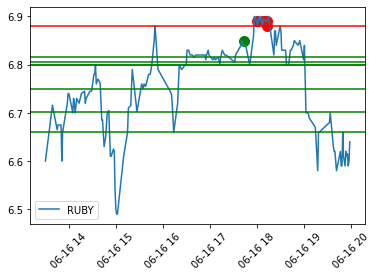

HMLP analysis for run 1528 with profit -4.94


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5198.07,-5198.07,buy,2020-06-16 17:58:33.325270,10.63,"[10.48, 10.5, 10.5801, 10.61]","[10.68, 10.68, 10.68]",489,"{'avg': 10.4721, 'rsi': 56.944073707946096, 'macd': [-0.0007330235703353338, -0.002169177062794958, -7.876538808027078e-05, 0.0031553607432552866, 0.006450982518595438], 'vwap': 10.63, 'supports': [10.25, 10.25, 10.395, 10.41, 10.41, 10.48, 10.5, 10.5801, 10.61], 'sell_macd': [-0.001072428398149583, -0.0019503083118195264, -0.0005311198249167148, 0.0016206000327336767, 0.003795698622687027], 'slow macd': [0.018514375999602706, 0.01770075847737651, 0.01756363854432763, 0.01772926528558294, 0.018013227728800985], 'macd_signal': [-0.002426541613516399, -0.0023750687033721107, -0.0019158080403137428, -0.000901574283599937, 0.0005689370768391382], 'resistances': [10.66, 10.68, 10.68, 10.68], 'position_ratio': '1.5', 'sell_macd_signal': [-0.002483401488946489, -0.0023767828535210963, -0.00200765024780022, -0.0012820001916934408, -0.00026646042881734713]}",11.03,10.43
1,-2594.59,2603.48,sell,2020-06-16 18:15:48.851556,10.67,None,None,244,"{'avg': 10.484, 'rsi': [63.210645823380915, 57.34963119471207], 'vwap': 10.6715, 'reasons': 'scale-out', 'movement': 0.003762935089369628, 'sell_macd': [0.01447180378037416, 0.014650542594450755, 0.014402150208089992, 0.016296881462768198, 0.016003206057806807], 'sell_macd_signal': [0.007471838459127735, 0.00890757928619234, 0.01000649347057187, 0.011264571069011135, 0.01221229806677027]}",11.03,10.43
2,-4.94,2589.65,sell,2020-06-16 19:45:21.806003,10.57,None,None,245,{'liquidation': 1},11.03,10.43


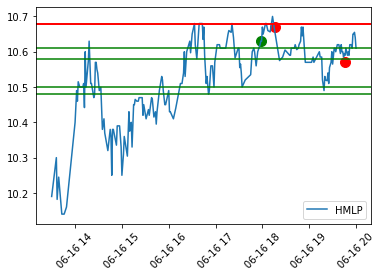

CUBI analysis for run 1528 with profit -106.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4991.43,-4991.43,buy,2020-06-16 18:30:24.595438,13.17,"[12.93, 12.96, 12.96, 13.03]","[13.3, 13.31]",379,"{'avg': 12.9055, 'rsi': 61.76740809701271, 'macd': [0.02351860215115309, 0.02487315808641455, 0.0232578026728838, 0.024519187432392897, 0.030413216090899198], 'vwap': 13.165, 'supports': [12.51, 12.67, 12.71, 12.79, 12.92, 12.93, 12.96, 12.96, 13.03], 'sell_macd': [0.014045206119224218, 0.014872260110207591, 0.01376512997187973, 0.014541845059262926, 0.01833484584087053], 'slow macd': [0.026339747488968612, 0.0267794643918009, 0.026661379919930894, 0.027069873366770025, 0.02844199009116366], 'macd_signal': [0.026270368933728704, 0.025990926764265874, 0.02544430194598946, 0.025259279043270147, 0.026290066452795958], 'resistances': [13.3, 13.31], 'position_ratio': '0.93', 'sell_macd_signal': [0.016118629331840113, 0.015869355487513608, 0.015448510384386832, 0.01526717731936205, 0.015880711023663747]}",13.69,12.91
1,-106.12,4885.31,sell,2020-06-16 19:09:19.037174,12.89,None,None,379,"{'avg': 12.921, 'rsi': [34.03395360976222, 31.339920667506497], 'vwap': 12.8985, 'reasons': 'stopped', 'movement': -0.020501138952163978, 'sell_macd': [-0.009819388681439278, -0.012867055381466486, -0.01611371702588471, -0.018694054449770903, -0.021760628358647338], 'sell_macd_signal': [-0.006430819463847613, -0.007718066647371387, -0.009397196723074052, -0.011256568268413421, -0.013357380286460205]}",13.69,12.91


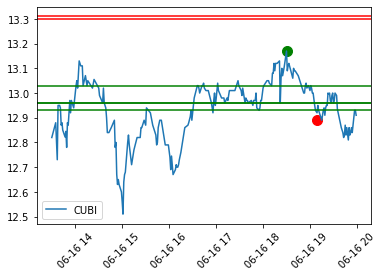

CDXC analysis for run 1528 with profit -107.69


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4346.76,-4346.76,buy,2020-06-16 17:58:28.358355,4.44,"[4.35, 4.36, 4.37, 4.37, 4.37, 4.39, 4.4]",[4.52],979,"{'avg': 4.323, 'rsi': 65.72229375797458, 'macd': [0.008185755649730453, 0.008708877017834737, 0.009019483479820956, 0.009957770782177633, 0.011377138089924799], 'vwap': 4.4394, 'supports': [4.23, 4.25, 4.26, 4.26, 4.27, 4.29, 4.34, 4.35, 4.36, 4.37, 4.37, 4.37, 4.39, 4.4], 'sell_macd': [0.0045788907934296574, 0.004927718633026323, 0.005135536188126899, 0.005750257189657937, 0.006674062422154847], 'slow macd': [0.014519181077973009, 0.014550053740116198, 0.014555186799144693, 0.014696566415949519, 0.0149630711071147], 'macd_signal': [0.008164244241429879, 0.00827317079671085, 0.008422433333332872, 0.008729500823101824, 0.009259028276466418], 'resistances': [4.52, 4.54], 'position_ratio': '2.0', 'sell_macd_signal': [0.004520655528220655, 0.004602068149181788, 0.00470876175697081, 0.0049170608435082355, 0.0052684611592375575]}",4.64,4.34
1,-107.69,4239.07,sell,2020-06-16 19:30:20.773565,4.33,None,None,979,"{'avg': 4.3489, 'rsi': [34.73224164047377, 27.835633785365964], 'vwap': 4.3486, 'reasons': 'stopped', 'movement': -0.024774774774774844, 'sell_macd': [-0.008927086691168817, -0.008501805690627862, -0.00806000483708047, -0.008390289823444697, -0.009837391243684657], 'sell_macd_signal': [-0.007883919720852874, -0.008007496914807871, -0.00801799849926239, -0.008092456764098852, -0.008441443660016012]}",4.64,4.34


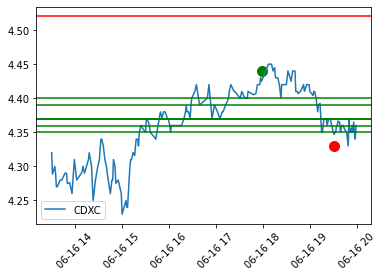

YRD analysis for run 1528 with profit -42.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3341.52,-3341.52,buy,2020-06-16 17:24:43.295465,4.76,"[4.42, 4.45, 4.55, 4.59, 4.6, 4.65, 4.68, 4.68, 4.68, 4.75, 4.7501]","[4.76, 4.76, 4.79, 4.8, 4.8]",702,"{'avg': 4.6758, 'rsi': 62.08743554254058, 'macd': [0.00808902806337386, 0.007621210362822595, 0.006370114325491727, 0.006912758577435341, 0.011247733320953301], 'vwap': 4.77, 'supports': [4.41, 4.42, 4.43, 4.45, 4.47, 4.49, 4.5, 4.5199, 4.52, 4.55, 4.59, 4.6, 4.65, 4.68, 4.68, 4.68, 4.75, 4.7501], 'sell_macd': [0.004277035242393978, 0.0039828985412135864, 0.0031824946371612484, 0.003556433223130817, 0.006399029092417408], 'slow macd': [0.02121470177564877, 0.02087565319600948, 0.020370393941897547, 0.020192831718994775, 0.020796853309648533], 'macd_signal': [0.013784365882216883, 0.012551734778338024, 0.011315410687768765, 0.01043488026570208, 0.010597450876752325], 'resistances': [4.79, 4.8, 4.8], 'position_ratio': '1.01', 'sell_macd_signal': [0.008040633052702672, 0.007229086150404855, 0.006419767847756134, 0.005847100922831071, 0.005957486556748338]}",5.05,4.63
1,-42.12,3299.40,sell,2020-06-16 19:45:06.399111,4.70,None,None,702,{'liquidation': 1},5.05,4.63


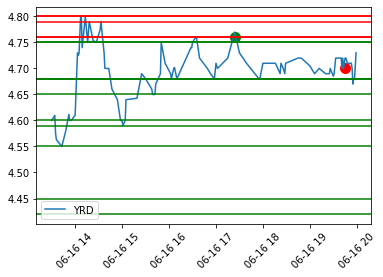

VBTX analysis for run 1528 with profit -120.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7038.59,-7038.59,buy,2020-06-16 18:05:34.669321,18.67,[18.46],"[19.12, 19.28, 19.28]",377,"{'avg': 18.4162, 'rsi': 64.05293930681917, 'macd': [0.024141197455907815, 0.028028816075298835, 0.03235069600701124, 0.03616583616995328, 0.03954048061476456], 'vwap': 18.6616, 'supports': [18.19, 18.23, 18.37, 18.4, 18.45, 18.46, 18.46], 'sell_macd': [0.014732893133373892, 0.017200984629351268, 0.01993974443622548, 0.022334365786566224, 0.02442972832206891], 'slow macd': [0.020949245142553252, 0.022039539293214006, 0.02332726767525628, 0.02463464629835954, 0.02595801280238419], 'macd_signal': [0.019973284166172677, 0.02158439054799791, 0.023737651639800576, 0.026223288545831117, 0.028886726959617807], 'resistances': [19.12], 'position_ratio': '2.14', 'sell_macd_signal': [0.012270255708626587, 0.013256401492771522, 0.014593070081462314, 0.016141329222483097, 0.01779900904240026]}",19.19,18.41
1,-120.64,6917.95,sell,2020-06-16 19:15:39.726088,18.35,None,None,377,"{'avg': 18.4467, 'rsi': [38.54009773502629, 30.661471711341466], 'vwap': 18.36, 'reasons': 'stopped', 'movement': -0.016604177825388443, 'sell_macd': [-0.017685494347905006, -0.01915522226377675, -0.019012734636355333, -0.019174267204125073, -0.022687483916623563], 'sell_macd_signal': [-0.014981920703626108, -0.015816581015656236, -0.016455811739796055, -0.01699950283266186, -0.0181370990494542]}",19.19,18.41


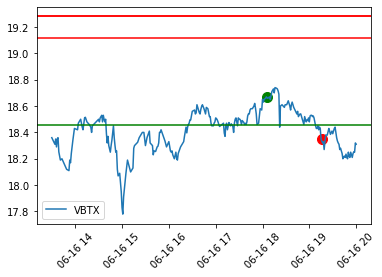

TOWN analysis for run 1528 with profit -108.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-10087.80,-10087.80,buy,2020-06-16 18:05:56.272627,19.55,"[19.39, 19.41, 19.44]","[20.13, 20.26]",516,"{'avg': 19.3206, 'rsi': 60.974402389610646, 'macd': [-0.001284712975408553, 0.0013717364791148157, 0.005830530365376063, 0.010852884203721658, 0.015461818017769247], 'vwap': 19.55, 'supports': [18.69, 19.17, 19.17, 19.2, 19.34, 19.39, 19.4, 19.41, 19.44], 'sell_macd': [-0.0018381336360526745, -3.2125274689320804e-05, 0.002934012737728864, 0.006246146088475513, 0.009265390958038466], 'slow macd': [0.02582857452759768, 0.02564220509908921, 0.025909536216484952, 0.026433922764368845, 0.027034033822197046], 'macd_signal': [0.0025446580353635897, 0.002310073724113835, 0.0030141650523662807, 0.004581908882637356, 0.006757890709663735], 'resistances': [20.13, 20.15, 20.21, 20.26], 'position_ratio': '5.27', 'sell_macd_signal': [0.0003733020737246008, 0.0002922166040418165, 0.000820575830779226, 0.0019056898823184834, 0.0033776300974624803]}",19.93,19.36
1,-108.36,9979.44,sell,2020-06-16 19:15:16.604135,19.34,None,None,516,"{'avg': 19.3572, 'rsi': [30.37531033524487, 26.692906778166854], 'vwap': 19.35, 'reasons': 'stopped', 'movement': -0.010230179028132955, 'sell_macd': [-0.0234340482727049, -0.02504372023491186, -0.025972766955657534, -0.026359390803570193, -0.027876767947347503], 'sell_macd_signal': [-0.01819778496074166, -0.019566972015575702, -0.02084813100359207, -0.021950382963587693, -0.023135659960339654]}",19.93,19.36


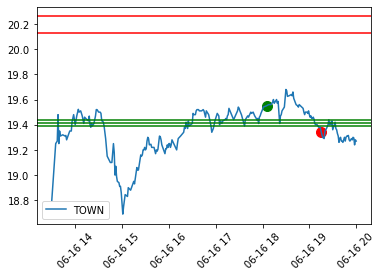

TCRR analysis for run 1528 with profit 2.17


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3461.15,-3461.15,buy,2020-06-16 17:48:51.349052,15.95,"[15.06, 15.2, 15.43, 15.58, 15.5881, 15.61, 15.63]","[16.475, 16.5456, 16.76, 16.7877, 17.1, 17.115, 17.24, 17.25, 17.25]",217,"{'avg': 15.3537, 'rsi': 66.85199101413708, 'macd': [0.06262404560447266, 0.06682903483183722, 0.06617107442784231, 0.0720809792460475, 0.08466473966776356], 'vwap': 15.99, 'supports': [14.17, 14.2237, 14.31, 14.37, 14.5527, 14.62, 14.68, 14.68, 14.71, 15.06, 15.2, 15.22, 15.43, 15.58, 15.5881, 15.61, 15.63], 'sell_macd': [0.032598139740446896, 0.035579271676333235, 0.03536224108512265, 0.0394092011298266, 0.04776515439674078], 'slow macd': [0.1348987642122843, 0.13468223385345723, 0.1336278694827744, 0.13388352566235362, 0.13566390581691756], 'macd_signal': [0.06625740347358347, 0.06637172974523423, 0.06633159868175584, 0.06748147479461417, 0.07091812776924404], 'resistances': [16.475, 16.5456], 'position_ratio': '1.35', 'sell_macd_signal': [0.0338834939960298, 0.03422264953209049, 0.03445056784269692, 0.03544229450012286, 0.037906866479446445]}",16.89,15.54
1,2.17,3463.32,sell,2020-06-16 19:45:06.070904,15.96,None,None,217,{'liquidation': 1},16.89,15.54


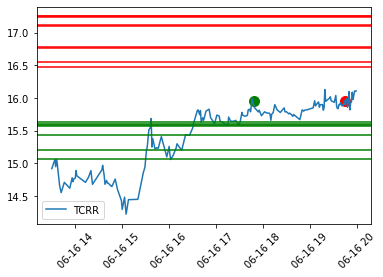

VG analysis for run 1524 with profit 14.11


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7441.80,-7441.80,buy,2020-06-16 18:10:42.760692,9.48,"[9.42, 9.43, 9.475, 9.48]","[9.5, 9.5, 9.5, 9.5]",785,"{'avg': 9.3631, 'rsi': 61.662752594280626, 'macd': [-0.00012582855426401807, 0.001181467466512487, 0.002989959021633126, 0.0039739343537448235, 0.005497288994531502], 'vwap': 9.485, 'supports': [9.27, 9.42, 9.43, 9.45, 9.47, 9.48], 'sell_macd': [0.00030881983839670113, 0.001140709512652549, 0.0022936013430765456, 0.0029024313233687593, 0.003858630901213189], 'slow macd': [0.0024361804055175185, 0.0025899855988615883, 0.0028872850020960072, 0.003076224141173256, 0.0034050702277212963], 'macd_signal': [-0.0029474336553751415, -0.002121653430997616, -0.0010993309404714676, -8.467788162820947e-05, 0.0010317154936037329], 'resistances': [9.49, 9.49, 9.49, 9.5, 9.5, 9.5], 'position_ratio': '1.0', 'sell_macd_signal': [-0.0015401497616128138, -0.0010039779067597412, -0.0003444620567924837, 0.00030491661923976495, 0.0010156594756344497]}",9.73,9.36
1,-3721.72,3720.08,sell,2020-06-16 18:11:47.518317,9.49,None,None,392,"{'avg': 9.3634, 'rsi': [59.91687329154798, 63.497286253280414], 'vwap': 9.49, 'reasons': 'scale-out', 'movement': 0.0010548523206750828, 'sell_macd': [0.001140709512652549, 0.0022936013430765456, 0.0029024313233687593, 0.0035988906414754496, 0.004614327894005399], 'sell_macd_signal': [-0.0010039779067597412, -0.0003444620567924837, 0.00030491661923976495, 0.0009637114236869019, 0.0016938347177506013]}",9.73,9.36
2,-1859.72,1862.00,sell,2020-06-16 18:11:52.893076,9.50,None,None,196,"{'avg': 9.3642, 'rsi': [63.497286253280414, 68.10022403467345], 'vwap': 9.505, 'reasons': 'scale-out', 'movement': 0.0015806111696523254, 'sell_macd': [0.0022936013430765456, 0.0029024313233687593, 0.0035988906414754496, 0.004614327894005399, 0.00612487214410784], 'sell_macd_signal': [-0.0003444620567924837, 0.00030491661923976495, 0.0009637114236869019, 0.0016938347177506013, 0.002580042203022049]}",9.73,9.36
3,-927.74,931.98,sell,2020-06-16 18:12:14.903274,9.51,None,None,98,"{'avg': 9.3642, 'rsi': [68.10022403467345, 69.48167073923851], 'vwap': 9.51, 'reasons': 'scale-out', 'movement': 0.001052631578947346, 'sell_macd': [0.0029024313233687593, 0.0035988906414754496, 0.004614327894005399, 0.00612487214410784, 0.007482116077380141], 'sell_macd_signal': [0.00030491661923976495, 0.0009637114236869019, 0.0016938347177506013, 0.002580042203022049, 0.0035604569778936676]}",9.73,9.36
4,-461.75,465.99,sell,2020-06-16 18:12:16.093473,9.51,None,None,49,"{'avg': 9.3644, 'rsi': [68.10022403467345, 69.48167073923851], 'vwap': 9.51, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.0029024313233687593, 0.0035988906414754496, 0.004614327894005399, 0.00612487214410784, 0.007482116077380141], 'sell_macd_signal': [0.00030491661923976495, 0.0009637114236869019, 0.0016938347177506013, 0.002580042203022049, 0.0035604569778936676]}",9.73,9.36
5,-224.00,237.75,sell,2020-06-16 18:12:17.183044,9.51,None,None,25,"{'avg': 9.3644, 'rsi': [68.10022403467345, 69.48167073923851], 'vwap': 9.51, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.0029024313233687593, 0.0035988906414754496, 0.004614327894005399, 0.00612487214410784, 0.007482116077380141], 'sell_macd_signal': [0.00030491661923976495, 0.0009637114236869019, 0.0016938347177506013, 0.002580042203022049, 0.0035604569778936676]}",9.73,9.36
6,-109.76,114.24,sell,2020-06-16 18:12:30.928311,9.52,None,None,12,"{'avg': 9.3644, 'rsi': [68.10022403467345, 71.91422692414595], 'vwap': 9.52, 'reasons': 'scale-out', 'movement': 0.0010515247108306822, 'sell_macd': [0.0029024313233687593, 0.0035988906414754496, 0.004614327894005399, 0.00612487214410784, 0.00800159659686095], 'sell_macd_signal': [0.00030491661923976495, 0.0009637114236869019, 0.0016938347177506013, 0.002580042203022049, 0.0036643530817898292]}",9.73,9.36
7,-62.11,47.65,sell,2020-06-16 18:12:49.018430,9.53,None,None,5,"{'avg': 9.3645, 'rsi': [68.1002240

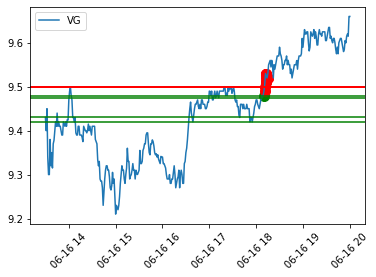

YEXT analysis for run 1524 with profit 50.19


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12617.64,-12617.64,buy,2020-06-16 17:31:47.977915,16.69,[16.62],"[16.77, 16.77, 16.7746, 16.87]",756,"{'avg': 16.6723, 'rsi': 63.28436611960249, 'macd': [0.009425190021925545, 0.008086027025427711, 0.008540118386857642, 0.012388308275305349, 0.015660954959699325], 'vwap': 16.6911, 'supports': [16.475, 16.55, 16.61, 16.62], 'sell_macd': [0.006162275746849133, 0.0052379478472452945, 0.005488628083305969, 0.007950344785644603, 0.010025054621422669], 'slow macd': [-0.0001748316387093496, -9.959781526092115e-05, 0.0002896510527961027, 0.0013670213211653959, 0.0024360180833546963], 'macd_signal': [0.007176290585681528, 0.007358237873630764, 0.00759461397627614, 0.008553352836081982, 0.00997487326080545], 'resistances': [16.77, 16.77], 'position_ratio': '1.14', 'sell_macd_signal': [0.004844047537417264, 0.00492282759938287, 0.0050359876961674896, 0.005618859114062912, 0.0065000982155348636]}",16.95,16.56
1,-6289.92,6327.72,sell,2020-06-16 17:45:07.555366,16.74,None,None,378,"{'avg': 16.6727, 'rsi': [57.29634064811048, 60.94883525750259], 'vwap': 16.74, 'reasons': 'scale-out', 'movement': 0.002995805871779338, 'sell_macd': [0.008846959442031732, 0.008963946173381032, 0.007380248221533492, 0.008647753087345222, 0.011081552293337182], 'sell_macd_signal': [0.011293921903092733, 0.010827926757150393, 0.010138391050027012, 0.009840263457490655, 0.01008852122465996]}",16.95,16.56
2,-3122.28,3167.64,sell,2020-06-16 18:20:40.145749,16.76,None,None,189,"{'avg': 16.6759, 'rsi': [56.64144779022933, 63.08401363994115], 'vwap': 16.76, 'reasons': 'scale-out', 'movement': 0.001194743130227188, 'sell_macd': [-0.0009513614138434434, 0.0012479850577342688, 0.005023476008865657, 0.006341735503138324, 0.009883993089545129], 'sell_macd_signal': [-0.0018418802397577494, -0.0012239071802593459, 2.5569457565654662e-05, 0.0012888026666801884, 0.0030078407512531763]}",16.95,16.56
3,-1544.96,1577.32,sell,2020-06-16 18:20:44.839462,16.78,None,None,94,"{'avg': 16.6762, 'rsi': [56.64144779022933, 64.14940806624429], 'vwap': 16.77, 'reasons': 'scale-out', 'movement': 0.000596658711217065, 'sell_macd': [-0.0009513614138434434, 0.0012479850577342688, 0.005023476008865657, 0.006341735503138324, 0.010403473609020608], 'sell_macd_signal': [-0.0018418802397577494, -0.0012239071802593459, 2.5569457565654662e-05, 0.0012888026666801884, 0.0031117368551482724]}",16.95,16.56
4,-755.83,789.13,sell,2020-06-16 19:03:38.855913,16.79,None,None,47,"{'avg': 16.6791, 'rsi': [62.6725467658077, 68.11846657133896], 'vwap': 16.7885, 'reasons': 'scale-out', 'movement': 0.0005959475566148992, 'sell_macd': [0.006060189462814947, 0.007562885309457812, 0.009674558887240892, 0.010934634936329957, 0.013592685949433303], 'sell_macd_signal': [0.004973125179737424, 0.005491077205681502, 0.00632777354199338, 0.007249145820860696, 0.008517853846575217]}",16.95,16.56
5,-352.87,402.96,sell,2020-06-16 19:03:44.700782,16.79,None,None,24,"{'avg': 16.6791, 'rsi': [68.11846657133896, 68.81835458173691], 'vwap': 16.7943, 'reasons': 'scale-out', 'movement': 0.0002977963073259415, 'sell_macd': [0.007562885309457812, 0.009674558887240892, 0.010934634936329957, 0.013592685949433303, 0.01574710640185728], 'sell_macd_signal': [0.005491077205681502, 0.00632777354199338, 0.007249145820860696, 0.008517853846575217, 0.00996370435763163]}",16.95,16.56
6,-151.27,201.60,sell,2020-06-16 19:03:47.955099,16.80,None,None,12,"{'avg': 16.6792, 'rsi': [68.11846657133896, 69.48817372432792], 'vwap': 16.8, 'reasons': 'scale-out', 'movement': 0.0005955926146516715, 'sell_macd': [0.007562885309457812, 0.009674558887240892, 0.010934634936329957, 0.013592685949433303, 0.016006846661596796], 'sell_macd_signal': [0.005491077205681502, 0.00632777354199338, 0.007249145820860696, 0.008517853846575217, 0.010015652409579533]}",16.95,16.56
7,-50.41,100.86,sell,2020-06-16 19:04:06.547079,16.81,None,None,6,"{'avg': 16.6792, 'rsi': [68.11846657133896,

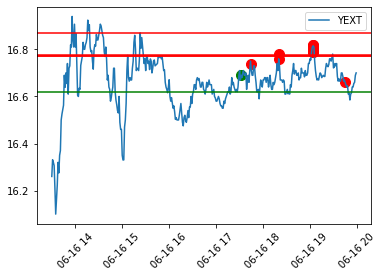

WWR analysis for run 1524 with profit 44.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1436.76,-1436.76,buy,2020-06-16 17:44:37.212929,2.34,"[2.178, 2.22, 2.23, 2.27, 2.28]",[2.39],614,"{'avg': 2.2499, 'rsi': 65.7255434463191, 'macd': [-0.007855363401996218, -0.0064976509370642255, -0.0066521764880485, -0.0014165235551950595, 0.005094788840119602], 'vwap': 2.34, 'supports': [2.13, 2.13, 2.1301, 2.15, 2.15, 2.15, 2.1519, 2.178, 2.22, 2.23, 2.27, 2.28], 'sell_macd': [-0.004747583675870803, -0.003838189209336651, -0.0039212819729548265, -0.0004961428020990866, 0.0037376817830105935], 'slow macd': [0.0033445668612044344, 0.003213484030471392, 0.002828647753126745, 0.003528838530742373, 0.004647200635969018], 'macd_signal': [-0.00866588425290204, -0.008232237589734476, -0.00791622536939728, -0.006616285006556836, -0.004274070237221548], 'resistances': [2.39], 'position_ratio': '0.83', 'sell_macd_signal': [-0.005456275223699725, -0.005132658020827111, -0.004890382811252654, -0.004011534809421941, -0.002461691490935434]}",2.66,2.18
1,-709.17,727.59,sell,2020-06-16 17:58:13.406570,2.37,None,None,307,"{'avg': 2.26, 'rsi': [58.995551609343934, 67.60850116676536], 'vwap': 2.3799, 'reasons': 'scale-out', 'movement': 0.017051282051282167, 'sell_macd': [0.01152284080223609, 0.01181856606091447, 0.011137071898054351, 0.010980880707539331, 0.013095785225222034], 'sell_macd_signal': [0.009080813794717039, 0.009628364247956525, 0.009930105777976091, 0.010140260763888739, 0.010731365656155397]}",2.66,2.18
2,-334.32,374.85,sell,2020-06-16 18:35:00.556416,2.45,None,None,153,"{'avg': 2.272, 'rsi': [53.50119609680321, 73.78627612620464], 'vwap': 2.4322, 'reasons': 'scale-out', 'movement': 0.03375527426160341, 'sell_macd': [0.005659790058348602, 0.005238207211920365, 0.003542971134029127, 0.0033084628767889868, 0.007664580301319113], 'sell_macd_signal': [0.005073123944148285, 0.005106140597702701, 0.004793506704967986, 0.004496497939332186, 0.005130114411729571]}",2.66,2.18
3,-145.67,188.65,sell,2020-06-16 18:35:03.802308,2.45,None,None,77,"{'avg': 2.2727, 'rsi': [53.50119609680321, 73.66906328928998], 'vwap': 2.4498, 'reasons': 'scale-out', 'movement': -0.00036734693877556033, 'sell_macd': [0.005659790058348602, 0.005238207211920365, 0.003542971134029127, 0.0033084628767889868, 0.007617827054565485], 'sell_macd_signal': [0.005073123944148285, 0.005106140597702701, 0.004793506704967986, 0.004496497939332186, 0.005120763762378846]}",2.66,2.18
4,-52.57,93.10,sell,2020-06-16 18:35:04.703619,2.45,None,None,38,"{'avg': 2.2729, 'rsi': [53.50119609680321, 73.78627612620464], 'vwap': 2.453, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.005659790058348602, 0.005238207211920365, 0.003542971134029127, 0.0033084628767889868, 0.007664580301319113], 'sell_macd_signal': [0.005073123944148285, 0.005106140597702701, 0.004793506704967986, 0.004496497939332186, 0.005130114411729571]}",2.66,2.18
5,-13.05,39.52,sell,2020-06-16 18:35:07.709082,2.47,None,None,16,"{'avg': 2.2729, 'rsi': [73.78627612620464, 73.78627612620464], 'vwap': 2.45, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.005238207211920365, 0.003542971134029127, 0.0033084628767889868, 0.007664580301319113, 0.010959417511325231], 'sell_macd_signal': [0.005106140597702701, 0.004793506704967986, 0.004496497939332186, 0.005130114411729571, 0.006295975031648703]}",2.66,2.18
6,-5.64,7.41,sell,2020-06-16 18:35:07.966659,2.47,None,None,3,"{'avg': 2.2729, 'rsi': [73.78627612620464, 73.78627612620464], 'vwap': 2.45, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.005238207211920365, 0.003542971134029127, 0.0033084628767889868, 0.007664580301319113, 0.010959417511325231], 'sell_macd_signal': [0.005106140597702701, 0.004793506704967986, 0.004496497939332186, 0.005130114411729571, 0.006295975031648703]}",2.66,2.18
7,19.26,24.90,sell,2020-06-16 18:35:14.751892,2.49,None,None,10,"{'avg': 2.273, 'rsi': [73.78627612620464, 77.88554597120009], 'vwap': 2.4851, 'reasons': 'scale-out', 'moveme

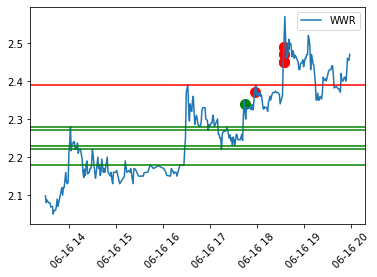

MLND analysis for run 1524 with profit -0.01


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2244.39,-2244.39,buy,2020-06-16 17:48:49.709466,2.37,"[2.31, 2.3184]",[2.4],947,"{'avg': 2.2804, 'rsi': 62.724868959038574, 'macd': [0.0020466273858898987, 0.0024628589479673835, 0.002362039129674809, 0.003364963327540327, 0.005396713473133197], 'vwap': 2.37, 'supports': [2.27, 2.31, 2.31, 2.3184, 2.335, 2.3647], 'sell_macd': [0.0014167698636224912, 0.0016707039299928006, 0.0015871369176840844, 0.002223485519551538, 0.0035268287739995685], 'slow macd': [0.0019434636343658163, 0.0020318788282640554, 0.002030005915768296, 0.00224734714115149, 0.0027012107041435307], 'macd_signal': [0.0011647392442291832, 0.0014243631849768232, 0.0016118983739164205, 0.001962511364641202, 0.002649351786339601], 'resistances': [2.4], 'position_ratio': '5.66', 'sell_macd_signal': [0.000908595825548085, 0.001061017446437028, 0.0011662413406864393, 0.001377690176459459, 0.001807517895967481]}",2.58,2.27
1,-1118.65,1125.74,sell,2020-06-16 19:29:18.698512,2.38,None,None,473,"{'avg': 2.2994, 'rsi': [64.59191805014864, 64.59191805014865], 'vwap': 2.3883, 'reasons': 'scale-out', 'movement': 0.008396624472573758, 'sell_macd': [0.0012582294772589542, 0.0016157653802211236, 0.002912341858110512, 0.0038796437648023208, 0.004583000526317882], 'sell_macd_signal': [0.00101960688567737, 0.0011388385845861207, 0.001493539239290999, 0.001970760144393263, 0.0024932082207781868]}",2.58,2.27
2,-0.01,1118.64,sell,2020-06-16 19:45:14.758465,2.36,None,None,474,{'liquidation': 1},2.58,2.27


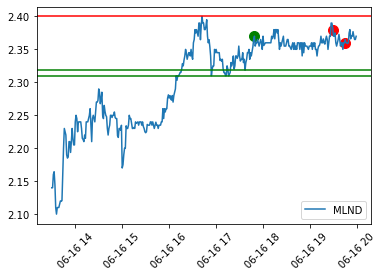

DCP analysis for run 1524 with profit -14.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1409.64,-1409.64,buy,2020-06-16 17:20:50.117048,13.82,[13.65],"[13.82, 13.85]",102,"{'avg': 13.6777, 'rsi': 69.98088279607327, 'macd': [0.10819236481314043, 0.11024921756971295, 0.11539063534116245, 0.11730609786476265, 0.12464948191755809], 'vwap': 13.8547, 'supports': [12.63, 12.78, 12.81, 12.93, 13.46], 'sell_macd': [0.05971061147520196, 0.06112166253103268, 0.06454427812608188, 0.06585353341928801, 0.07069381633062655], 'slow macd': [0.10521045774784277, 0.10723129740560822, 0.10987864921004409, 0.1119786259814024, 0.11517100184984308], 'macd_signal': [0.13159244679281185, 0.12732380094819207, 0.12493716782678614, 0.12341095383438144, 0.12365865945101677], 'resistances': [14.53, 14.6, 14.6, 14.72], 'position_ratio': '1.61', 'sell_macd_signal': [0.07560231330072997, 0.07270618314679052, 0.07107380214264879, 0.07002974839797663, 0.07016256198450661]}",14.85,13.38
1,-14.28,1395.36,sell,2020-06-16 19:45:19.931681,13.68,None,None,102,{'liquidation': 1},14.85,13.38


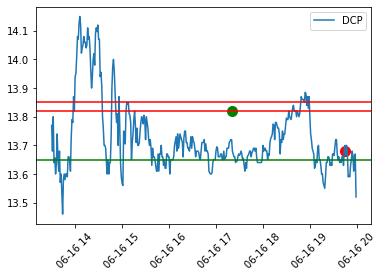

LTHM analysis for run 1524 with profit -102.18


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6193.68,-6193.68,buy,2020-06-16 17:48:32.266215,7.88,"[7.8, 7.81]","[7.94, 7.96, 7.99]",786,"{'avg': 7.8452, 'rsi': 65.4563691472707, 'macd': [-0.0004189843670623361, 0.0014613541472625613, 0.0025190398305969808, 0.003717864342261734, 0.006210187086816532], 'vwap': 7.8727, 'supports': [7.7899, 7.8, 7.81, 7.815], 'sell_macd': [-0.0004366397043318315, 0.0008020956688303826, 0.0014971869249453817, 0.0022791127488677176, 0.003897767770769889], 'slow macd': [-0.000978965277187882, -0.0005761646599520276, -0.00028462172556587007, 6.403032518331742e-05, 0.000704571007899446], 'macd_signal': [-0.000320814261893342, 3.561941993783865e-05, 0.0005323035020696671, 0.0011694156701080806, 0.0021775699534497713], 'resistances': [7.94, 7.96, 7.99], 'position_ratio': '0.92', 'sell_macd_signal': [-0.00041402905934890915, -0.00017080411371305076, 0.00016279409401863575, 0.0005860578249884522, 0.0012483998141447396]}",8.13,7.75
1,-102.18,6091.50,sell,2020-06-16 17:51:58.888259,7.75,None,None,786,"{'avg': 7.8446, 'rsi': [39.41608506100573, 27.91703139729554], 'vwap': 7.75, 'reasons': 'stopped', 'movement': -0.016497461928933997, 'sell_macd': [0.0022791127488677176, 0.0033782872512890805, 0.0026324714447172326, 0.0004586867714833076, -0.004358011503393655], 'sell_macd_signal': [0.0005860578249884522, 0.0011445037102485779, 0.0014420972571423088, 0.0012454151600105085, 0.00012472982732967576]}",8.13,7.75


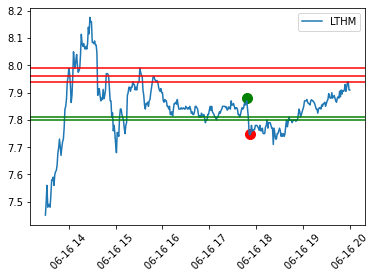

COOP analysis for run 1524 with profit -108.24


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4628.08,-4628.08,buy,2020-06-16 18:18:13.506502,14.11,"[13.91, 14.0, 14.01]",[14.19],328,"{'avg': 13.8628, 'rsi': 62.56371317453282, 'macd': [0.008400366348412902, 0.007454023066822302, 0.010089748153134792, 0.012845490050921171, 0.01725132213550218], 'vwap': 14.11, 'supports': [13.815, 13.87, 13.91, 14.0, 14.01], 'sell_macd': [0.005936399970769557, 0.005273925523580303, 0.006943764583905221, 0.008679434441511091, 0.01147762609105385], 'slow macd': [0.009442739398979327, 0.00924393255079714, 0.009740361863924463, 0.010343049749589994, 0.011360807696778608], 'macd_signal': [-0.0036578204480839606, -0.0014354517451027077, 0.0008695882345447921, 0.003264768597820068, 0.00606207930535649], 'resistances': [14.19], 'position_ratio': '0.8', 'sell_macd_signal': [-0.002092234241939285, -0.0006190022888353675, 0.0008935510857127503, 0.0024507277568724187, 0.004256107423708705]}",14.71,13.81
1,-108.24,4519.84,sell,2020-06-16 18:52:15.712053,13.78,None,None,328,"{'avg': 13.8666, 'rsi': [35.6230471677484, 32.95040328076228], 'vwap': 13.8081, 'reasons': 'stopped', 'movement': -0.021970233876683114, 'sell_macd': [-0.018736850988217313, -0.019224953734410022, -0.02138159283878771, -0.02257661561052693, -0.02451330068447355], 'sell_macd_signal': [-0.02096258130560417, -0.02061505579136534, -0.020768363200849814, -0.021130013682785238, -0.0218066710831229]}",14.71,13.81


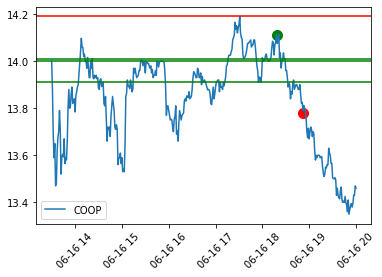

VIVO analysis for run 1526 with profit 37.63


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9414.57,-9414.57,buy,2020-06-16 17:47:34.251389,18.21,"[17.86, 18.1, 18.11]",[18.329],517,"{'avg': 17.8829, 'rsi': 60.45989771308926, 'macd': [0.01935686553983018, 0.023101547139358303, 0.024184684607483575, 0.026353129237982387, 0.028549453330388275], 'vwap': 18.22, 'supports': [17.61, 17.85, 17.86, 18.1], 'sell_macd': [0.008793209383611611, 0.011377743446324473, 0.012210136956927187, 0.013739143108605134, 0.01527162656304526], 'slow macd': [0.050949136604589995, 0.05120074872695568, 0.05103207879438898, 0.05111515043372705, 0.05126976348465817], 'macd_signal': [0.028361994144194137, 0.02730990474322697, 0.02668486071607829, 0.02661851442045911, 0.027004702202444945], 'resistances': [18.329], 'position_ratio': '0.91', 'sell_macd_signal': [0.014293673845944118, 0.013710487766020189, 0.013410417604201589, 0.013476162705082298, 0.01383525547667489]}",18.6,18.03
1,-4698.33,4716.24,sell,2020-06-16 18:16:44.866889,18.28,None,None,258,"{'avg': 17.9156, 'rsi': [56.08689520871807, 58.58818283009425], 'vwap': 18.2675, 'reasons': 'scale-out', 'movement': 0.0032948929159801604, 'sell_macd': [0.01115218550102881, 0.01342304964980201, 0.01345978730274311, 0.013313611612790766, 0.014065765469805314], 'sell_macd_signal': [0.010102901871151178, 0.010766931426881345, 0.011305502602053697, 0.011707124404201111, 0.012178852617321951]}",18.6,18.03
2,-2336.34,2361.99,sell,2020-06-16 18:19:54.509954,18.31,None,None,129,"{'avg': 17.9175, 'rsi': [60.099591542468346, 62.48134426510708], 'vwap': 18.2996, 'reasons': 'scale-out', 'movement': 0.0016411378555797364, 'sell_macd': [0.013313611612790766, 0.01510472650876693, 0.016823715693828234, 0.017425217452398556, 0.018706579635018983], 'sell_macd_signal': [0.011707124404201111, 0.012386644825114274, 0.013274058998857067, 0.014104290689565365, 0.015024748478656088]}",18.6,18.03
3,-1144.89,1191.45,sell,2020-06-16 18:20:39.789979,18.33,None,None,65,"{'avg': 17.9193, 'rsi': [62.48134426510708, 64.74752050015896], 'vwap': 18.33, 'reasons': 'scale-out', 'movement': 0.0010922992900054382, 'sell_macd': [0.01510472650876693, 0.016823715693828234, 0.017425217452398556, 0.018706579635018983, 0.02050106211972036], 'sell_macd_signal': [0.012386644825114274, 0.013274058998857067, 0.014104290689565365, 0.015024748478656088, 0.016120011206868942]}",18.6,18.03
4,-612.74,532.15,sell,2020-06-16 18:20:52.574759,18.35,None,None,29,"{'avg': 17.9199, 'rsi': [62.48134426510708, 65.78095810615986], 'vwap': 18.334, 'reasons': 'scale-out', 'movement': 0.000545553737043184, 'sell_macd': [0.01510472650876693, 0.016823715693828234, 0.017425217452398556, 0.018706579635018983, 0.021020542639202944], 'sell_macd_signal': [0.012386644825114274, 0.013274058998857067, 0.014104290689565365, 0.015024748478656088, 0.016223907310765458]}",18.6,18.03
5,-557.69,55.05,sell,2020-06-16 18:20:52.712600,18.35,None,None,3,"{'avg': 17.9199, 'rsi': [62.48134426510708, 65.78095810615986], 'vwap': 18.334, 'reasons': 'scale-out', 'movement': 0.000545553737043184, 'sell_macd': [0.01510472650876693, 0.016823715693828234, 0.017425217452398556, 0.018706579635018983, 0.021020542639202944], 'sell_macd_signal': [0.012386644825114274, 0.013274058998857067, 0.014104290689565365, 0.015024748478656088, 0.016223907310765458]}",18.6,18.03
6,37.63,595.32,sell,2020-06-16 19:45:10.953141,18.04,None,None,33,{'liquidation': 1},18.6,18.03


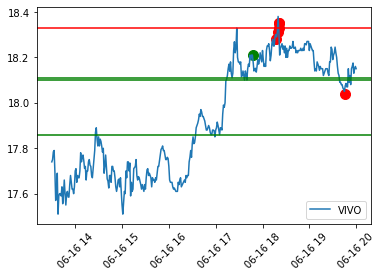

MRC analysis for run 1526 with profit -79.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6008.52,-6008.52,buy,2020-06-16 18:04:03.467505,6.44,[6.39],"[6.58, 6.595, 6.6]",933,"{'avg': 6.3229, 'rsi': 63.951505396504594, 'macd': [-0.0017785852105243194, -0.0011588900765131527, 0.0017329951718032532, 0.003978967999723082, 0.006092149354933518], 'vwap': 6.4425, 'supports': [6.27, 6.28, 6.37, 6.375, 6.38, 6.39, 6.4], 'sell_macd': [-0.0012057405974941204, -0.0007888605996857478, 0.0011046674583425897, 0.0025657975365671604, 0.003930758668475143], 'slow macd': [0.005848747021669709, 0.00574192448814248, 0.006114269011293416, 0.006447058964003105, 0.006822893208435765], 'macd_signal': [-0.0010225060792748957, -0.0010497828787225472, -0.0004932272686173871, 0.0004012117850507067, 0.001539399299027269], 'resistances': [6.58, 6.595, 6.6], 'position_ratio': '3.0', 'sell_macd_signal': [-0.0007731739858443922, -0.0007763113086126633, -0.0004001155552216127, 0.00019306706313614188, 0.0009406053842039421]}",6.66,6.34
1,18.66,6027.18,sell,2020-06-16 18:23:47.954220,6.46,None,None,933,"{'avg': 6.3389, 'rsi': [55.57071658864538, 59.07691812174711], 'vwap': 6.48, 'reasons': 'bail', 'movement': 0.006211180124223607, 'sell_macd': [0.012167293123665601, 0.012736750039026745, 0.013015070362177639, 0.011504474894994843, 0.01069745927257948], 'sell_macd_signal': [0.009858693726049148, 0.010434304988644668, 0.010950458063351261, 0.011061261429679978, 0.01098850099825988]}",6.66,6.34
2,-5823.26,-5841.92,buy,2020-06-16 18:30:13.105025,6.52,"[6.39, 6.44, 6.47]","[6.58, 6.595, 6.6]",896,"{'avg': 6.35, 'rsi': 69.72204325557878, 'macd': [0.015842253455842226, 0.015379965145707608, 0.01484250319166236, 0.015847711026052202, 0.017252387123923185], 'vwap': 6.512, 'supports': [6.28, 6.37, 6.375, 6.38, 6.39, 6.4, 6.44, 6.47], 'sell_macd': [0.00933401807338008, 0.009005140232956954, 0.008631921912718, 0.009267960599379954, 0.010162692555228503], 'slow macd': [0.013816478799173026, 0.013957444757527249, 0.014064814965902173, 0.014460976337196563, 0.014962265185656243], 'macd_signal': [0.017138374637221683, 0.01678669273891887, 0.016397854829467567, 0.016287826068784494, 0.01648073827981223], 'resistances': [6.58], 'position_ratio': '1.2', 'sell_macd_signal': [0.010366491442046669, 0.010094221200228726, 0.00980176134272658, 0.009695001194057255, 0.009788539466291504]}",6.74,6.41
3,-887.56,4935.70,sell,2020-06-16 19:18:28.269213,6.41,None,None,770,"{'avg': 6.3696, 'rsi': [29.454532567882584, 27.06645057084164], 'vwap': 6.41, 'reasons': 'stopped', 'movement': -0.016871165644171692, 'sell_macd': [-0.0027313378255691134, -0.003813107490376666, -0.004606524015027702, -0.006681828787288069, -0.008773211352850474], 'sell_macd_signal': [-0.0010699159182726893, -0.0016185542326934846, -0.0022161481891603283, -0.0031092843087858766, -0.004242069717598796]}",6.74,6.41
4,-79.90,807.66,sell,2020-06-16 19:18:28.468203,6.41,None,None,126,"{'avg': 6.3696, 'rsi': [29.454532567882584, 27.06645057084164], 'vwap': 6.41, 'reasons': 'stopped', 'movement': -0.016871165644171692, 'sell_macd': [-0.0027313378255691134, -0.003813107490376666, -0.004606524015027702, -0.006681828787288069, -0.008773211352850474], 'sell_macd_signal': [-0.0010699159182726893, -0.0016185542326934846, -0.0022161481891603283, -0.0031092843087858766, -0.004242069717598796]}",6.74,6.41


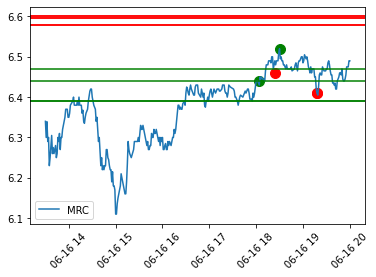

HOPE analysis for run 1526 with profit -103.93


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5393.42,-5393.42,buy,2020-06-16 18:30:11.168106,9.86,"[9.74, 9.76]",[10.08],547,"{'avg': 9.7302, 'rsi': 61.60422896785559, 'macd': [0.0038815636009275067, 0.004389890551804498, 0.003940404367428485, 0.006734221124771622, 0.010441807232378864], 'vwap': 9.85, 'supports': [9.74, 9.75, 9.755, 9.755, 9.755, 9.76, 9.77], 'sell_macd': [0.0023348690947724293, 0.0026538725274605213, 0.0023485002343939243, 0.0041579698731162296, 0.006552907645197337], 'slow macd': [0.00554812809081362, 0.00563774802190764, 0.005551248409496168, 0.0061025316554790265, 0.006919841780383962], 'macd_signal': [0.004630733848106687, 0.00458256518884625, 0.004454133024562696, 0.004910150644604481, 0.006016481962159358], 'resistances': [10.08, 10.08, 10.13], 'position_ratio': '2.44', 'sell_macd_signal': [0.0029035683277119245, 0.002853629167661644, 0.0027526033810081002, 0.003033676679429726, 0.003737522872583248]}",10.22,9.68
1,-4851.90,541.52,sell,2020-06-16 19:19:38.274694,9.67,None,None,56,"{'avg': 9.7344, 'rsi': [24.334564974582815, 21.618769046413504], 'vwap': 9.675, 'reasons': 'stopped', 'movement': -0.01876267748478689, 'sell_macd': [-0.007903340795362368, -0.008788348778951516, -0.010402792028772367, -0.012045179080208968, -0.013947751080285897], 'sell_macd_signal': [-0.006027998533792128, -0.006580068582824006, -0.007344613272013678, -0.008284726433652736, -0.009417331362979368]}",10.22,9.68
2,-103.93,4747.97,sell,2020-06-16 19:19:38.489205,9.67,None,None,491,"{'avg': 9.7344, 'rsi': [24.334564974582815, 21.618769046413504], 'vwap': 9.675, 'reasons': 'stopped', 'movement': -0.01876267748478689, 'sell_macd': [-0.007903340795362368, -0.008788348778951516, -0.010402792028772367, -0.012045179080208968, -0.013947751080285897], 'sell_macd_signal': [-0.006027998533792128, -0.006580068582824006, -0.007344613272013678, -0.008284726433652736, -0.009417331362979368]}",10.22,9.68


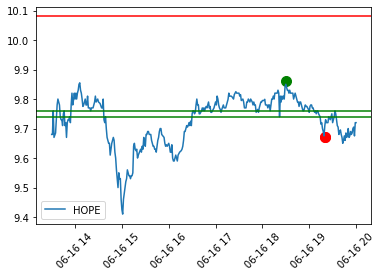

HOMB analysis for run 1526 with profit -21.06


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-11239.02,-11239.02,buy,2020-06-16 18:15:40.200188,16.01,[15.94],[16.01],702,"{'avg': 15.7898, 'rsi': 68.63219667595145, 'macd': [0.010494351237969823, 0.013535144485578243, 0.016162146095691554, 0.019232735435858572, 0.02301473294811629], 'vwap': 16.0275, 'supports': [15.8, 15.83, 15.86, 15.87, 15.92, 15.94], 'sell_macd': [0.006656581681195206, 0.008589253026078936, 0.010243422216557718, 0.01217857454398974, 0.014567283181676771], 'slow macd': [0.009252864762242297, 0.009976591797842715, 0.010706455668984205, 0.011600734335445395, 0.012724817611809769], 'macd_signal': [0.009417939234786777, 0.01024138028494507, 0.011425533447094367, 0.012986973844847208, 0.014992525665501025], 'resistances': [16.18], 'position_ratio': '1.67', 'sell_macd_signal': [0.0061228192000189, 0.006616105965230907, 0.007341569215496269, 0.008308970281194964, 0.009560632861291326]}",16.31,15.89
1,-5587.92,5651.10,sell,2020-06-16 18:30:30.896122,16.10,None,None,351,"{'avg': 15.8089, 'rsi': [56.771604912941044, 61.866562688960855], 'vwap': 16.1, 'reasons': 'scale-out', 'movement': 0.005621486570893183, 'sell_macd': [0.0077727724923946084, 0.008248178028258835, 0.006433582627268564, 0.00831268254042783, 0.012526102180029142], 'sell_macd_signal': [0.01226984586114112, 0.011465512294564663, 0.010459126361105443, 0.010029837596969921, 0.010529090513581765]}",16.31,15.89
2,-21.06,5566.86,sell,2020-06-16 19:01:20.884104,15.86,None,None,351,"{'avg': 15.8226, 'rsi': [34.72695889345114, 29.84375263498021], 'vwap': 15.85, 'reasons': 'stopped', 'movement': -0.015527950310559115, 'sell_macd': [-0.013753319567015865, -0.014591939793504594, -0.0155753849077378, -0.017178389088856605, -0.020282309371690843], 'sell_macd_signal': [-0.00882731293595886, -0.009980238307468007, -0.011099267627521964, -0.012315091919788893, -0.013908535410169284]}",16.31,15.89


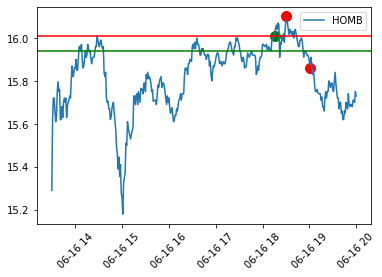

FLXN analysis for run 1526 with profit 23.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7005.36,-7005.36,buy,2020-06-16 17:29:54.078308,12.12,"[11.98, 11.995, 12.0]",[12.2821],578,"{'avg': 11.9464, 'rsi': 68.29285727532246, 'macd': [0.016534108141110337, 0.01576850965426857, 0.0172226018978634, 0.018963299787882804, 0.02250415084373536], 'vwap': 12.1025, 'supports': [11.695, 11.78, 11.86, 11.98, 11.995, 12.0], 'sell_macd': [0.009833994953600822, 0.00932063334207811, 0.010254109575409842, 0.01136780391858494, 0.01364642543380512], 'slow macd': [0.019981330816273513, 0.019906587317381153, 0.020253803974629392, 0.020700797302270146, 0.0215587455060664], 'macd_signal': [0.012016114920169432, 0.01276659386698926, 0.013657795473164088, 0.014718896336107831, 0.016275947237633336], 'resistances': [12.2821], 'position_ratio': '1.35', 'sell_macd_signal': [0.006827555220694174, 0.007326170844970961, 0.007911758591058738, 0.008602967656563978, 0.009611659212012206]}",12.46,11.95
1,23.12,7028.48,sell,2020-06-16 18:43:41.779785,12.16,None,None,578,"{'avg': 11.9823, 'rsi': [57.139915267161676, 53.46279922914163], 'vwap': 12.17, 'reasons': 'bail', 'movement': 0.004125412541254184, 'sell_macd': [0.009208515267255635, 0.00784618153327088, 0.0066775295128493894, 0.007763287295471599, 0.007469549369002237], 'sell_macd_signal': [0.008567650373546816, 0.008423356605491629, 0.00807419118696318, 0.008012010408664864, 0.007903518200732339]}",12.46,11.95


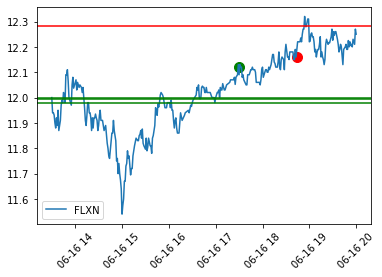

PINE analysis for run 1529 with profit -13.08


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3727.80,-3727.80,buy,2020-06-16 18:23:51.789943,17.10,"[16.835, 16.85, 16.85, 16.85, 16.86, 16.925, 16.935]","[17.14, 17.24, 17.5, 17.9]",218,"{'avg': 16.9753, 'rsi': 68.96751285238444, 'macd': [0.056820039447263326, 0.06736588473833649, 0.0829095995989988, 0.08609388218670588, 0.09319160920343705], 'vwap': 17.1933, 'supports': [16.53, 16.72, 16.81, 16.835, 16.85, 16.85, 16.85, 16.85, 16.85, 16.86, 16.925, 16.935, 17.14], 'sell_macd': [0.03673963641747946, 0.04336715988591422, 0.053209812460202954, 0.05494681690172243, 0.05922309546782145], 'slow macd': [0.021140015209265783, 0.024650479850880203, 0.02945454911155565, 0.03221358356672255, 0.03582001457314732], 'macd_signal': [0.026806786821518706, 0.034918606404882264, 0.04451680504370557, 0.05283222047230564, 0.06090409821853192], 'resistances': [17.5, 17.9], 'position_ratio': '1.77', 'sell_macd_signal': [0.017558735990623346, 0.02272042076968152, 0.028818299107785807, 0.034044002666573134, 0.0390798212268228]}",18.17,16.82
1,-1768.20,1959.60,sell,2020-06-16 18:39:31.899590,17.04,None,None,115,"{'avg': 16.9833, 'rsi': [51.85110380191382, 59.789483987026514], 'vwap': 17.21, 'reasons': 'bail', 'movement': 0.006432748538011662, 'sell_macd': [0.05329565890589549, 0.053449390959890763, 0.05287503423625495, 0.04517456101996231, 0.04515374343558065], 'sell_macd_signal': [0.040800910840559215, 0.043330606864425525, 0.04523949233879141, 0.04522650607502559, 0.0452119535471366]}",18.17,16.82
2,-13.08,1755.12,sell,2020-06-16 18:39:32.065951,17.04,None,None,103,"{'avg': 16.9833, 'rsi': [51.85110380191382, 59.789483987026514], 'vwap': 17.21, 'reasons': 'bail', 'movement': 0.006432748538011662, 'sell_macd': [0.05329565890589549, 0.053449390959890763, 0.05287503423625495, 0.04517456101996231, 0.04515374343558065], 'sell_macd_signal': [0.040800910840559215, 0.043330606864425525, 0.04523949233879141, 0.04522650607502559, 0.0452119535471366]}",18.17,16.82


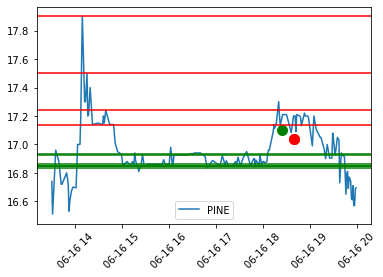

LMNR analysis for run 1529 with profit -85.41


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-7582.14,-7582.14,buy,2020-06-16 17:52:14.191455,14.78,"[14.53, 14.6, 14.66, 14.6807]","[14.86, 15.185, 15.21, 15.21, 15.525, 16.07]",513,"{'avg': 14.4233, 'rsi': 68.51235228581112, 'macd': [0.07944443608272245, 0.07449343473304104, 0.07369828057322714, 0.07542631329048888, 0.07671834674941991], 'vwap': 14.7697, 'supports': [13.82, 14.04, 14.07, 14.175, 14.21, 14.2201, 14.29, 14.29, 14.42, 14.53, 14.6, 14.66, 14.6807], 'sell_macd': [0.046524698348914484, 0.043214762885119384, 0.042635400668070034, 0.0437081651655884, 0.04449592756410148], 'slow macd': [0.06496704811371856, 0.06531049175815795, 0.06631050049819187, 0.06776423024981959, 0.06915326473102645], 'macd_signal': [0.0768596080956516, 0.07638637342312948, 0.07584875485314901, 0.07576426654061699, 0.07595508258237757], 'resistances': [14.86, 15.21], 'position_ratio': '0.81', 'sell_macd_signal': [0.04527810138964268, 0.04486543368873802, 0.044419427084604425, 0.04427717470080122, 0.04432092527346127]}",15.08,14.63
1,-9710.46,-2128.32,buy,2020-06-16 17:52:14.379205,14.78,"[14.53, 14.6, 14.66, 14.6807]","[14.86, 15.185, 15.21, 15.21, 15.525, 16.07]",144,"{'avg': 14.4233, 'rsi': 68.51235228581112, 'macd': [0.07944443608272245, 0.07449343473304104, 0.07369828057322714, 0.07542631329048888, 0.07671834674941991], 'vwap': 14.7697, 'supports': [13.82, 14.04, 14.07, 14.175, 14.21, 14.2201, 14.29, 14.29, 14.42, 14.53, 14.6, 14.66, 14.6807], 'sell_macd': [0.046524698348914484, 0.043214762885119384, 0.042635400668070034, 0.0437081651655884, 0.04449592756410148], 'slow macd': [0.06496704811371856, 0.06531049175815795, 0.06631050049819187, 0.06776423024981959, 0.06915326473102645], 'macd_signal': [0.0768596080956516, 0.07638637342312948, 0.07584875485314901, 0.07576426654061699, 0.07595508258237757], 'resistances': [14.86, 15.21], 'position_ratio': '0.81', 'sell_macd_signal': [0.04527810138964268, 0.04486543368873802, 0.044419427084604425, 0.04427717470080122, 0.04432092527346127]}",15.08,14.63
2,-85.41,9625.05,sell,2020-06-16 17:52:19.798789,14.65,None,None,657,"{'avg': 14.4246, 'rsi': [68.51235228581112, 50.4246213521942], 'vwap': 14.63, 'reasons': 'stopped', 'movement': -0.01014884979702291, 'sell_macd': [0.043214762885119384, 0.042635400668070034, 0.0437081651655884, 0.04449592756410148, 0.03673969141276068], 'sell_macd_signal': [0.04486543368873802, 0.044419427084604425, 0.04427717470080122, 0.04432092527346127, 0.04280467850132115]}",15.08,14.63


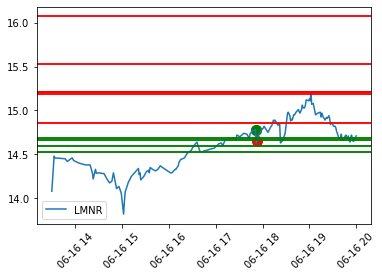

MIRM analysis for run 1529 with profit -118.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3530.8,-3530.8,buy,2020-06-16 17:36:40.545560,19.40,"[18.3948, 18.8521, 18.91, 18.94, 18.95, 18.99, 19.2166, 19.28]",[19.5695],182,"{'avg': 19.0275, 'rsi': 62.92204628629548, 'macd': [0.06070758357631689, 0.07170266290889415, 0.07949991693972791, 0.08191087189904422, 0.0880515246802851], 'vwap': 19.3903, 'supports': [17.44, 17.79, 17.85, 18.3356, 18.3948, 18.8521, 18.91, 18.94, 18.95, 18.99, 19.2166, 19.28], 'sell_macd': [0.035783781291840455, 0.04295372955376564, 0.04798286158183984, 0.04946032989485971, 0.053345885334941556], 'slow macd': [0.11609877159127535, 0.11738528931185854, 0.11838118540054765, 0.11854833140553467, 0.11955209375333808], 'macd_signal': [0.03513071751548011, 0.04244510659416292, 0.04985606866327592, 0.05626702931042958, 0.06262392838440069], 'resistances': [19.5695], 'position_ratio': '1.41', 'sell_macd_signal': [0.01817830589151738, 0.02313339062396703, 0.028103284815541592, 0.03237469383140522, 0.036568932132112486]}",20.48,18.86
1,-118.3,3412.5,sell,2020-06-16 19:43:35.015380,18.75,None,None,182,"{'avg': 19.0695, 'rsi': [45.90362943975769, 38.956803135812365], 'vwap': 18.8766, 'reasons': 'stopped', 'movement': -0.02783505154639171, 'sell_macd': [-0.021841705050754, -0.023141788250310213, -0.026965985701259854, -0.025959308576009477, -0.03211047823716129], 'sell_macd_signal': [-0.012536877342329385, -0.014657859523925551, -0.01711948475939241, -0.018887449522715823, -0.021532055265604914]}",20.48,18.86


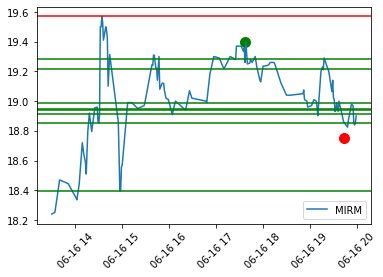

FHB analysis for run 1513 with profit -99.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-74.44,-74.44,buy,2020-06-16 14:07:03.874183,18.61,[18.3],[19.03],4,"{'avg': 18.4297, 'rsi': 69.49269620064892, 'macd': [0.0876674396548971, 0.08550369498493637, 0.08642379594169469, 0.09134497138141384, 0.09415962482983886], 'vwap': 18.61, 'supports': [17.48, 17.72, 18.3], 'sell_macd': [0.04770372175805804, 0.046446896495911716, 0.047202008025461595, 0.05055401690529848, 0.05250942620250498], 'slow macd': [0.10647464630548953, 0.1067897650798777, 0.10762860124123108, 0.1092678046008082, 0.11060116554122956], 'macd_signal': [0.09718051303645081, 0.09484514942614793, 0.09316087872925728, 0.09279769725968859, 0.09307008277371864], 'resistances': [18.945], 'position_ratio': '1.08', 'sell_macd_signal': [0.05355918148770654, 0.05213672448934757, 0.051149781196570376, 0.051030628338315995, 0.05132638791115379]}",19.33,18.25
1,-5154.97,-5080.53,buy,2020-06-16 14:07:04.178229,18.61,[18.3],[19.03],273,"{'avg': 18.4297, 'rsi': 69.49269620064892, 'macd': [0.0876674396548971, 0.08550369498493637, 0.08642379594169469, 0.09134497138141384, 0.09415962482983886], 'vwap': 18.61, 'supports': [17.48, 17.72, 18.3], 'sell_macd': [0.04770372175805804, 0.046446896495911716, 0.047202008025461595, 0.05055401690529848, 0.05250942620250498], 'slow macd': [0.10647464630548953, 0.1067897650798777, 0.10762860124123108, 0.1092678046008082, 0.11060116554122956], 'macd_signal': [0.09718051303645081, 0.09484514942614793, 0.09316087872925728, 0.09279769725968859, 0.09307008277371864], 'resistances': [18.945], 'position_ratio': '1.08', 'sell_macd_signal': [0.05355918148770654, 0.05213672448934757, 0.051149781196570376, 0.051030628338315995, 0.05132638791115379]}",19.33,18.25
2,-99.72,5055.25,sell,2020-06-16 14:44:34.755928,18.25,None,None,277,"{'avg': 18.4656, 'rsi': [30.910235174377704, 26.294162501452075], 'vwap': 18.25, 'reasons': 'stopped', 'movement': -0.019344438473938713, 'sell_macd': [-0.01055883910574451, -0.017345633148782014, -0.023967217686877262, -0.02881563138296528, -0.03585575073858038], 'sell_macd_signal': [-0.0005755836005418864, -0.003929593510189912, -0.007937118345527383, -0.012112820953014962, -0.016861406910128045]}",19.33,18.25


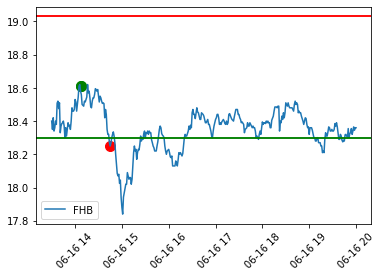

BHR analysis for run 1513 with profit -95.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1788.80,-1788.80,buy,2020-06-16 14:29:58.588947,4.30,"[4.03, 4.06, 4.12, 4.17]","[4.55, 4.55]",416,"{'avg': 4.1789, 'rsi': 68.31179101971607, 'macd': [0.01955045790967258, 0.014986425905745726, 0.014063763499184923, 0.021157817015421188, 0.029665604619133923], 'vwap': 4.2993, 'supports': [3.79, 3.84, 3.85, 3.875, 4.03, 4.06, 4.12], 'sell_macd': [0.009614792974011799, 0.006727540415667477, 0.006229323611560034, 0.010955007613404177, 0.01657300803544537], 'slow macd': [0.03967838492557085, 0.03856068744170926, 0.038036871104191405, 0.03909346891424903, 0.04064279225902556], 'macd_signal': [0.031765868913095865, 0.028409980311625838, 0.025540736949137655, 0.02466415296239436, 0.025664443293742272], 'resistances': [4.55, 4.55], 'position_ratio': '1.39', 'sell_macd_signal': [0.017447735353335693, 0.01530369636580205, 0.013488821814953648, 0.012982058974643754, 0.013700248786804077]}",4.78,4.06
1,-95.68,1693.12,sell,2020-06-16 14:54:47.866980,4.07,None,None,416,"{'avg': 4.171, 'rsi': [43.77442817225703, 39.75980833623898], 'vwap': 4.0647, 'reasons': 'stopped', 'movement': -0.05581395348837215, 'sell_macd': [-0.012532147724837017, -0.012487473614236855, -0.013848929195402704, -0.01369098641195432, -0.014948550653268278], 'sell_macd_signal': [-0.00907827986312202, -0.009760118613344988, -0.01057788072975653, -0.011200501866196089, -0.011950111623610527]}",4.78,4.06


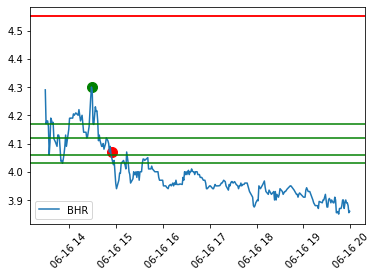

OII analysis for run 1513 with profit -96.9


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4003.5,-4003.5,buy,2020-06-16 14:20:16.581479,7.85,"[7.62, 7.7301]","[8.03, 8.05]",510,"{'avg': 7.759, 'rsi': 66.5912135660232, 'macd': [0.02605416066933408, 0.025202772412889374, 0.0264422514437328, 0.031100621038339327, 0.0359913593698602], 'vwap': 7.865, 'supports': [7.07, 7.205, 7.62, 7.7301], 'sell_macd': [0.012417445228690482, 0.012028244849141778, 0.012997332282622232, 0.016181071421923043, 0.01949072436914534], 'slow macd': [0.07001131704170138, 0.06910308841875601, 0.06859679237114591, 0.06882095295689705, 0.06923699042030584], 'macd_signal': [0.036193915360596685, 0.033995686771055224, 0.03248499970559074, 0.03220812397214046, 0.032964771051684404], 'resistances': [8.03, 8.05, 8.055], 'position_ratio': '1.14', 'sell_macd_signal': [0.018450599002999973, 0.017166128172228335, 0.016332368994307116, 0.016302109479830303, 0.01693983245769331]}",8.26,7.67
1,-96.9,3906.6,sell,2020-06-16 14:37:16.243973,7.66,None,None,510,"{'avg': 7.7727, 'rsi': [38.115422264121115, 33.28508547794831], 'vwap': 7.675, 'reasons': 'stopped', 'movement': -0.022292993630573226, 'sell_macd': [0.014178565052038294, 0.00772289379497515, 0.001033761727198268, -0.00367249393246194, -0.009629673746061052], 'sell_macd_signal': [0.019444897631218268, 0.017100496863969646, 0.01388714983661537, 0.010375221082799908, 0.006374242117027715]}",8.26,7.67


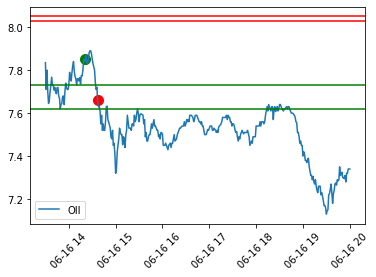

CNDT analysis for run 1513 with profit -98.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1988.0,-1988.0,buy,2020-06-16 14:06:09.400361,2.84,"[2.75, 2.78]","[2.94, 2.945, 2.96, 2.98]",700,"{'avg': 2.7981, 'rsi': 67.83291331345048, 'macd': [0.021634629189357657, 0.022168939917002195, 0.02233492194103137, 0.023087928689874193, 0.02355039347953891], 'vwap': 2.8412, 'supports': [2.58, 2.625, 2.63, 2.63, 2.75, 2.78], 'sell_macd': [0.01188470087250515, 0.012261407058915097, 0.012395705294313775, 0.012910798655736855, 0.01323280908469382], 'slow macd': [0.024779977673383247, 0.025106662927135037, 0.025367069211491344, 0.025742009868611415, 0.026072985643325275], 'macd_signal': [0.023785961824444028, 0.02346255744295566, 0.023237030342570804, 0.023207210012031482, 0.023275846705532968], 'resistances': [2.945], 'position_ratio': '1.63', 'sell_macd_signal': [0.013249271123697996, 0.013051698310741416, 0.012920499707455887, 0.01291855949711208, 0.012981409414628428]}",3.13,2.7
1,-98.0,1890.0,sell,2020-06-16 14:41:45.007842,2.70,None,None,700,"{'avg': 2.7893, 'rsi': [28.476323724934872, 24.917364813205907], 'vwap': 2.7099, 'reasons': 'stopped', 'movement': -0.04929577464788722, 'sell_macd': [-0.00803864050203762, -0.009429124749804618, -0.009870682283781296, -0.011645003968908885, -0.013915319516165425], 'sell_macd_signal': [-0.003420869665757713, -0.004622520682567094, -0.005672153002809934, -0.006866723196029724, -0.008276442460056864]}",3.13,2.7


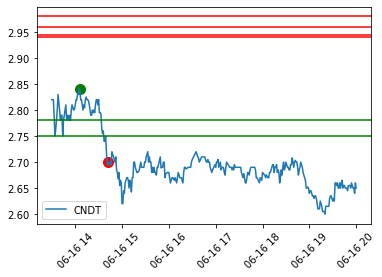

ISBC analysis for run 1513 with profit -102.95


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3187.90,-3187.90,buy,2020-06-16 14:05:45.442845,8.98,"[8.33, 8.36, 8.75]",[9.245],355,"{'avg': 8.8479, 'rsi': 69.17949139446604, 'macd': [0.05844026959444193, 0.056251698951195195, 0.055890263843794585, 0.05736332449932213, 0.059459160346252204], 'vwap': 8.9722, 'supports': [8.33, 8.36, 8.385, 8.44, 8.75], 'sell_macd': [0.03229852486529872, 0.030945997730546182, 0.030788885706966695, 0.031825046653437994, 0.033258093538306], 'slow macd': [0.06632542409060527, 0.06647856082247294, 0.06691296841013283, 0.0676854274207539, 0.0686077330879904], 'macd_signal': [0.06111198530547207, 0.060139928034616694, 0.05928999519645227, 0.05890466105702624, 0.05901556091487144], 'resistances': [9.185], 'position_ratio': '0.89', 'sell_macd_signal': [0.033881630902008, 0.03329450426771564, 0.03279338055556585, 0.032599713775140274, 0.03273138972777342]}",9.54,8.7
1,-102.95,3084.95,sell,2020-06-16 14:54:30.764339,8.69,None,None,355,"{'avg': 8.8585, 'rsi': [26.183937049626003, 22.85679454971301], 'vwap': 8.6985, 'reasons': 'stopped', 'movement': -0.032293986636971146, 'sell_macd': [-0.02052757582408482, -0.021312476541801573, -0.022686263119998884, -0.025280301192360355, -0.02879149577871587], 'sell_macd_signal': [-0.018002569882688703, -0.018664551214511278, -0.0194688935956088, -0.02063117511495911, -0.02226323924771046]}",9.54,8.7


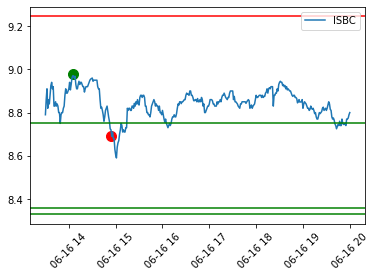

CERS analysis for run 1511 with profit 53.82


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5208.68,-5208.68,buy,2020-06-16 14:24:37.130489,6.61,[6.55],[6.61],788,"{'avg': 6.5326, 'rsi': 64.90509621946964, 'macd': [0.015579546017852941, 0.015189321035925296, 0.015109351935715942, 0.01646197612289413, 0.017852642068713287], 'vwap': 6.6164, 'supports': [6.2601, 6.275, 6.435, 6.55], 'sell_macd': [0.008060778898955512, 0.007871249425414284, 0.007881080362584392, 0.0088201553738525, 0.009775017001153685], 'slow macd': [0.03319130942659232, 0.03287105519998246, 0.03260380642100191, 0.032624056454541694, 0.03269446793049369], 'macd_signal': [0.016766734812682677, 0.016451252057331202, 0.01618287203300815, 0.016238692850985344, 0.01656148269453093], 'resistances': [6.69], 'position_ratio': '1.11', 'sell_macd_signal': [0.008526861451825612, 0.008395739046543347, 0.008292807309751555, 0.008398276922571744, 0.008673624938288133]}",6.87,6.49
1,-2584.64,2624.04,sell,2020-06-16 14:26:12.847260,6.66,None,None,394,"{'avg': 6.5453, 'rsi': [63.76309517814924, 72.08515571766858], 'vwap': 6.6553, 'reasons': 'scale-out', 'movement': 0.00906202723146745, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.01048151050764723, 0.011120468916998583, 0.014066144704584005], 'sell_macd_signal': [0.008292807309751555, 0.008398276922571744, 0.00881492363958684, 0.00927603269506919, 0.010234055096972153]}",6.87,6.49
2,-1268.68,1315.96,sell,2020-06-16 14:26:26.221823,6.68,None,None,197,"{'avg': 6.5461, 'rsi': [63.76309517814924, 73.32510336486985], 'vwap': 6.6768, 'reasons': 'scale-out', 'movement': 0.003003003003002939, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.01048151050764723, 0.011120468916998583, 0.014590820029258822], 'sell_macd_signal': [0.008292807309751555, 0.008398276922571744, 0.00881492363958684, 0.00927603269506919, 0.010338990161907115]}",6.87,6.49
3,-611.10,657.58,sell,2020-06-16 14:26:40.991897,6.71,None,None,98,"{'avg': 6.5482, 'rsi': [63.76309517814924, 74.1768629491292], 'vwap': 6.6875, 'reasons': 'scale-out', 'movement': 0.0011227544910180067, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.01048151050764723, 0.011120468916998583, 0.014980430418869872], 'sell_macd_signal': [0.008292807309751555, 0.008398276922571744, 0.00881492363958684, 0.00927603269506919, 0.010416912239829327]}",6.87,6.49
4,-282.31,328.79,sell,2020-06-16 14:26:44.679219,6.71,None,None,49,"{'avg': 6.5571, 'rsi': [63.76309517814924, 76.4343011122769], 'vwap': 6.71, 'reasons': 'scale-out', 'movement': 0.0, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.01048151050764723, 0.011120468916998583, 0.016149261587701247], 'sell_macd_signal': [0.008292807309751555, 0.008398276922571744, 0.00881492363958684, 0.00927603269506919, 0.0106506784735956]}",6.87,6.49
5,-114.56,167.75,sell,2020-06-16 14:26:45.757317,6.71,None,None,25,"{'avg': 6.5586, 'rsi': [63.76309517814924, 75.95790654352368], 'vwap': 6.7109, 'reasons': 'scale-out', 'movement': -0.0007600596125185783, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.01048151050764723, 0.011120468916998583, 0.015884326522765946], 'sell_macd_signal': [0.008292807309751555, 0.008398276922571744, 0.00881492363958684, 0.00927603269506919, 0.01059769146060854]}",6.87,6.49
6,-33.80,80.76,sell,2020-06-16 14:26:47.850645,6.73,None,None,12,"{'avg': 6.5591, 'rsi': [63.76309517814924, 75.96743267275774], 'vwap': 6.705, 'reasons': 'scale-out', 'movement': -0.0007451564828613851, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.01048151050764723, 0.011120468916998583, 0.015889521327960843], 'sell_macd_signal': [0.008292807309751555, 0.008398276922571744, 0.00881492363958684, 0.00927603269506919, 0.01059873042164752]}",6.87,6.49
7,6.64,40.44,sell,2020-06-16 14:26:50.795346,6.74,None,None,6,"{'avg': 6.5605, 'rsi': [63.76309517814924, 77.14469838959123], 'vwap': 6.7199, 'reasons': 'scale-out', 'movement': -0.00178306092124821, 'sell_macd': [0.007881080362584392, 0.0088201553738525, 0.010481

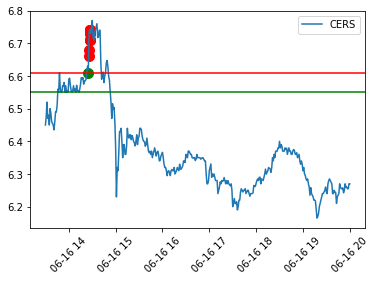

BKD analysis for run 1511 with profit 28.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1115.56,-1115.56,buy,2020-06-16 13:59:07.692834,3.34,"[2.98, 3.22, 3.22, 3.22]",[3.545],334,"{'avg': 3.2541, 'rsi': 69.337403221466, 'macd': [0.03250411882466864, 0.03468323695858322, 0.03439983108676614, 0.036976651773100055, 0.03937186283193039], 'vwap': 3.335, 'supports': [2.98, 3.015, 3.22, 3.22], 'sell_macd': [0.01814925293094527, 0.01957825224398002, 0.019398534147072155, 0.021084487134584773, 0.02264387274648305], 'slow macd': [0.03064177046095029, 0.03157078394932267, 0.03205514096689477, 0.033089241300187755, 0.034147661092953197], 'macd_signal': [0.03773445480733739, 0.03712421123758656, 0.03657933520742247, 0.03665879852055799, 0.03720141138283247], 'resistances': [3.545, 3.56, 3.5906], 'position_ratio': '1.71', 'sell_macd_signal': [0.02177711688179059, 0.021337343954228476, 0.02094958199279721, 0.020976563021154724, 0.02131002496622039]}",3.69,3.17
1,-1903.80,-788.24,buy,2020-06-16 13:59:07.993992,3.34,"[2.98, 3.22, 3.22, 3.22]",[3.545],236,"{'avg': 3.2541, 'rsi': 69.337403221466, 'macd': [0.03250411882466864, 0.03468323695858322, 0.03439983108676614, 0.036976651773100055, 0.03937186283193039], 'vwap': 3.335, 'supports': [2.98, 3.015, 3.22, 3.22], 'sell_macd': [0.01814925293094527, 0.01957825224398002, 0.019398534147072155, 0.021084487134584773, 0.02264387274648305], 'slow macd': [0.03064177046095029, 0.03157078394932267, 0.03205514096689477, 0.033089241300187755, 0.034147661092953197], 'macd_signal': [0.03773445480733739, 0.03712421123758656, 0.03657933520742247, 0.03665879852055799, 0.03720141138283247], 'resistances': [3.545, 3.56, 3.5906], 'position_ratio': '1.71', 'sell_macd_signal': [0.02177711688179059, 0.021337343954228476, 0.02094958199279721, 0.020976563021154724, 0.02131002496622039]}",3.69,3.17
2,28.50,1932.30,sell,2020-06-16 14:17:40.819892,3.39,None,None,570,"{'avg': 3.2764, 'rsi': [65.6972334133419, 66.64234252341812], 'vwap': 3.3955, 'reasons': 'bail', 'movement': 0.016467065868263523, 'sell_macd': [0.019137507665314413, 0.017967876433070185, 0.016823126428294533, 0.016751592315114916, 0.01673803856049272], 'sell_macd_signal': [0.0223926262060185, 0.021507676251428836, 0.020570766286801975, 0.019806931492464562, 0.019193152906070193]}",3.69,3.17


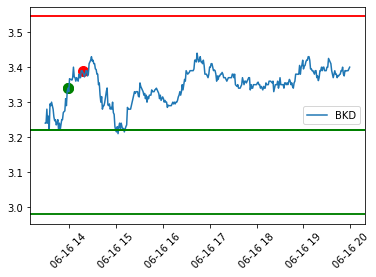

SVC analysis for run 1511 with profit -97.44


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1740.48,-1740.48,buy,2020-06-16 14:14:02.861790,10.36,"[9.33, 9.85, 10.13, 10.25]","[10.845, 11.03]",168,"{'avg': 10.1648, 'rsi': 68.57789947669947, 'macd': [0.09595623077838233, 0.08683234162862696, 0.08467735905684037, 0.08760804383328313, 0.0920966653096027], 'vwap': 10.3713, 'supports': [9.215, 9.23, 9.35, 9.85], 'sell_macd': [0.05480030149659676, 0.048863931543378314, 0.04749969610524296, 0.04945613997026399, 0.05241627622910627], 'slow macd': [0.11338869916005123, 0.11229843712697374, 0.11231527571688993, 0.1132706873492495, 0.11460828007882284], 'macd_signal': [0.09720169401770103, 0.09512782353988622, 0.09303773064327706, 0.09195179328127827, 0.09198076768694316], 'resistances': [10.845, 11.03], 'position_ratio': '0.9', 'sell_macd_signal': [0.05547706495893064, 0.05415443827582018, 0.052823489841704735, 0.05215001986741659, 0.05220327113975452]}",11.56,9.78
1,-97.44,1643.04,sell,2020-06-16 14:58:05.786750,9.78,None,None,168,"{'avg': 10.1496, 'rsi': [25.198716909648216, 24.67802025919506], 'vwap': 9.78, 'reasons': 'stopped', 'movement': -0.055984555984556, 'sell_macd': [-0.03957316823095525, -0.043795608086988125, -0.045997566311339, -0.05127185107951604, -0.0552352956900517], 'sell_macd_signal': [-0.03462905550214178, -0.03646236601911105, -0.038369406077556636, -0.040949895077948516, -0.04380697520036915]}",11.56,9.78


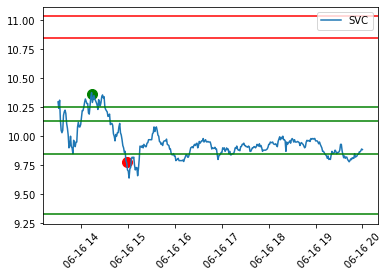

CHNG analysis for run 1511 with profit -102.41


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6365.59,-6365.59,buy,2020-06-16 14:30:00.999784,11.81,"[11.68, 11.7]",[11.81],539,"{'avg': 11.682, 'rsi': 65.95139309254469, 'macd': [0.012111323917391559, 0.01447439687317953, 0.021346042102093676, 0.025289968795949136, 0.028091735079783575], 'vwap': 11.815, 'supports': [11.15, 11.17, 11.305, 11.475, 11.68, 11.7], 'sell_macd': [0.0049805612093862806, 0.006661392571126967, 0.011261243079353278, 0.013920071487328656, 0.01581110568202071], 'slow macd': [0.050875122620823277, 0.05053824668403628, 0.05118706534965867, 0.05146222867960404, 0.051633081101631007], 'macd_signal': [0.016841712270479155, 0.01636824919101923, 0.017363807773234118, 0.01894903997777712, 0.020777578998178413], 'resistances': [12.01, 12.01, 12.02], 'position_ratio': '1.7', 'sell_macd_signal': [0.007441979829566868, 0.007285862377878888, 0.008080938518173765, 0.009248765112004743, 0.010561233226007936]}",12.19,11.63
1,-102.41,6263.18,sell,2020-06-16 14:45:49.956006,11.62,None,None,539,"{'avg': 11.7007, 'rsi': [30.72035405843864, 27.61762279096142], 'vwap': 11.62, 'reasons': 'stopped', 'movement': -0.016088060965283764, 'sell_macd': [0.003275073857217592, -0.0020414545305751375, -0.008235613605082293, -0.012955275044889802, -0.018023124542859037], 'sell_macd_signal': [0.013846565814575478, 0.010668961745545356, 0.006888046675419826, 0.0029193823313579, -0.0012691190434854878]}",12.19,11.63


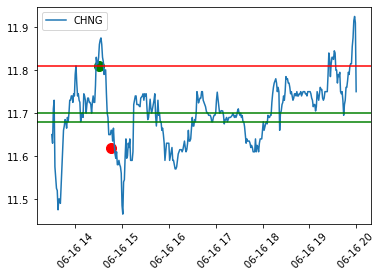

GPRO analysis for run 1511 with profit -98.26


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2745.50,-2745.50,buy,2020-06-16 14:06:22.961341,4.75,"[4.5899, 4.61, 4.64]",[5.03],578,"{'avg': 4.6918, 'rsi': 69.19023739324948, 'macd': [0.023637094993686603, 0.026633419008975423, 0.02686662535703377, 0.02935171152309568, 0.030748839299661768], 'vwap': 4.7522, 'supports': [4.47, 4.64], 'sell_macd': [0.012937305325454673, 0.014932995428944551, 0.015114922841678258, 0.016759088061449212, 0.017682345530602106], 'slow macd': [0.03009703763301541, 0.030852686140597996, 0.0311355076005686, 0.031868906300685396, 0.03244950397512181], 'macd_signal': [0.023325025804848007, 0.02398670444567349, 0.024562688627945545, 0.025520493206975574, 0.026566162425512813], 'resistances': [5.03], 'position_ratio': '2.39', 'sell_macd_signal': [0.012555881273558347, 0.013031304104635589, 0.013448027852044122, 0.01411023989392514, 0.014824661021260534]}",5.1,4.58
1,-98.26,2647.24,sell,2020-06-16 14:58:51.844951,4.58,None,None,578,"{'avg': 4.6923, 'rsi': [33.48579953113819, 28.684230461998016], 'vwap': 4.5831, 'reasons': 'stopped', 'movement': -0.03578947368421051, 'sell_macd': [-0.007740307250329259, -0.008977896551908948, -0.008786694753764479, -0.01059632069347316, -0.013432440637486387], 'sell_macd_signal': [-0.006738009405346674, -0.007185986834659129, -0.007506128418480199, -0.008124166873478791, -0.00918582162628031]}",5.1,4.58


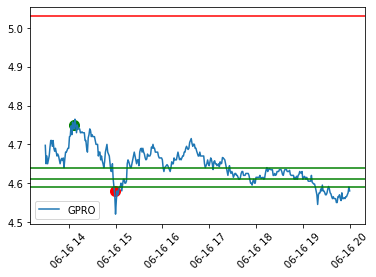

PBR.A analysis for run 1511 with profit -74.88


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5353.92,-5353.92,buy,2020-06-16 14:16:27.682725,8.58,[8.47],"[8.7, 8.77]",624,"{'avg': 8.5061, 'rsi': 69.93866767584197, 'macd': [0.025024901651141462, 0.025292603322911944, 0.026011827101957152, 0.02707661123537619, 0.029197720043775632], 'vwap': 8.58, 'supports': [8.07, 8.08, 8.09, 8.11, 8.115, 8.45, 8.47], 'sell_macd': [0.012949119660403241, 0.013220215595627138, 0.013779248589365523, 0.014555387953453902, 0.016010101900102214], 'slow macd': [0.04826015651896043, 0.04806998613614688, 0.04797807810120247, 0.047976721563491864, 0.0482186134949103], 'macd_signal': [0.02885728370273812, 0.028144347626772884, 0.027717843521809737, 0.027589597064523026, 0.027911221660373547], 'resistances': [8.7], 'position_ratio': '1.09', 'sell_macd_signal': [0.015043609840030699, 0.014678930991149986, 0.014498994510793093, 0.014510273199325255, 0.014810238939480646]}",8.9,8.42
1,-74.88,5279.04,sell,2020-06-16 14:40:43.958130,8.46,None,None,624,"{'avg': 8.5121, 'rsi': [36.94213971594631, 32.0573258219316], 'vwap': 8.42, 'reasons': 'stopped', 'movement': -0.018648018648018665, 'sell_macd': [-0.0013466181521994969, -0.005435408024901278, -0.007511927302006782, -0.009811657552971198, -0.013294412845242576], 'sell_macd_signal': [0.004370039394072474, 0.0024089499102777235, 0.00042477446782082217, -0.0016225119363375822, -0.003956892118118581]}",8.9,8.42


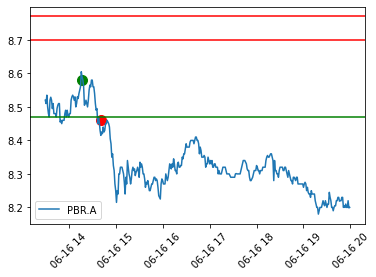

DCP analysis for run 1512 with profit -1378.33


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2805.46,-2805.46,buy,2020-06-16 13:59:01.599598,13.82,"[12.63, 12.6899, 12.78, 13.46, 13.49, 13.59]",[14.6],203,"{'avg': 13.6777, 'rsi': 69.98088279607327, 'macd': [0.10819236481314043, 0.11024921756971295, 0.11539063534116245, 0.11730609786476265, 0.12464948191755809], 'vwap': 13.8547, 'supports': [12.63, 12.78, 12.81, 12.93, 13.46], 'sell_macd': [0.05971061147520196, 0.06112166253103268, 0.06454427812608188, 0.06585353341928801, 0.07069381633062655], 'slow macd': [0.10521045774784277, 0.10723129740560822, 0.10987864921004409, 0.1119786259814024, 0.11517100184984308], 'macd_signal': [0.13159244679281185, 0.12732380094819207, 0.12493716782678614, 0.12341095383438144, 0.12365865945101677], 'resistances': [14.53, 14.6, 14.6, 14.72], 'position_ratio': '1.61', 'sell_macd_signal': [0.07560231330072997, 0.07270618314679052, 0.07107380214264879, 0.07002974839797663, 0.07016256198450661]}",14.85,13.38
1,-1378.33,1427.13,sell,2020-06-16 14:05:24.080630,14.13,None,None,101,"{'avg': 13.7099, 'rsi': [74.19873780872625, 76.16905931918355], 'vwap': 14.1119, 'reasons': 'scale-out', 'movement': 0.022431259044862553, 'sell_macd': [0.08036129549121362, 0.08539509890725405, 0.09183968470017767, 0.09514923616609039, 0.09961448099451431], 'sell_macd_signal': [0.0733109887294328, 0.07572781076499704, 0.07895018555203318, 0.08218999567484461, 0.08567489273877855]}",14.85,13.38


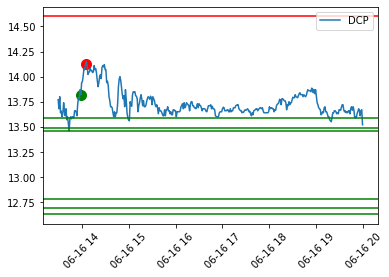

STAY analysis for run 1512 with profit -102.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6885.6,-6885.6,buy,2020-06-16 14:31:22.477024,12.08,[11.975],[12.085],570,"{'avg': 11.9217, 'rsi': 69.24671895995276, 'macd': [0.027926286795894484, 0.03051746474371342, 0.032598672939368356, 0.035453195908166535, 0.03768448090186105], 'vwap': 12.095, 'supports': [11.32, 11.39, 11.83, 11.975], 'sell_macd': [0.014352063867933751, 0.016150943913620708, 0.017602656365925284, 0.019544215986346813, 0.021063038859578498], 'slow macd': [0.06346104225372784, 0.0634380887703827, 0.06339547848639349, 0.06357475550462333, 0.06371798517152882], 'macd_signal': [0.03314788968747749, 0.03262180469872468, 0.03261717834685342, 0.03318438185911604, 0.03408440166766504], 'resistances': [12.355, 12.38], 'position_ratio': '2.17', 'sell_macd_signal': [0.017337113985438756, 0.017099879971075146, 0.017200435250045172, 0.017669191397305502, 0.018347960889760102]}",12.45,11.92
1,-102.6,6783.0,sell,2020-06-16 14:44:12.876623,11.90,None,None,570,"{'avg': 11.9456, 'rsi': [37.786633955553775, 33.90482629232057], 'vwap': 11.92, 'reasons': 'stopped', 'movement': -0.013245033112582794, 'sell_macd': [0.009352915344189583, 0.005737042762810063, 0.0031047129232568693, -0.001324436470202528, -0.00631696279666194], 'sell_macd_signal': [0.013686748314398495, 0.012096807204080809, 0.010298388347916021, 0.007973823384292311, 0.005115666148101461]}",12.45,11.92


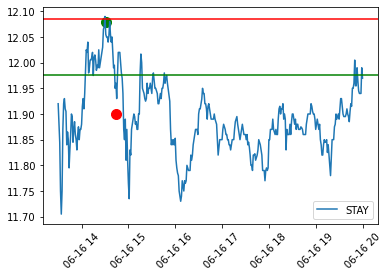

SAN analysis for run 1510 with profit -99.99


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1263.60,-1263.60,buy,2020-06-16 14:29:43.564911,2.60,"[2.565, 2.57]",[2.73],486,"{'avg': 2.5676, 'rsi': 63.94989624654023, 'macd': [0.004713468441789548, 0.004898733000042288, 0.005386917676735603, 0.005708009173555517, 0.006692248845724169], 'vwap': 2.6, 'supports': [2.43, 2.44, 2.54, 2.55, 2.565, 2.57], 'sell_macd': [0.0022688877240031324, 0.002417806465168759, 0.002762187218477319, 0.0029946632961403985, 0.003656402274888837], 'slow macd': [0.014214319904295447, 0.014071671650881967, 0.013997893035245124, 0.013907626675100815, 0.01396227145663076], 'macd_signal': [0.00655332312125651, 0.006222405097013666, 0.0060553076129580535, 0.0059858479250775466, 0.006127128109206871], 'resistances': [2.73, 2.74, 2.74, 2.75], 'position_ratio': '4.33', 'sell_macd_signal': [0.0033677974438716144, 0.0031777992481310433, 0.0030946768422002984, 0.0030746741329883186, 0.003191019761368422]}",2.78,2.51
1,-2888.60,-1625.00,buy,2020-06-16 14:29:43.701748,2.60,"[2.565, 2.57]",[2.73],625,"{'avg': 2.5676, 'rsi': 63.94989624654023, 'macd': [0.004713468441789548, 0.004898733000042288, 0.005386917676735603, 0.005708009173555517, 0.006692248845724169], 'vwap': 2.6, 'supports': [2.43, 2.44, 2.54, 2.55, 2.565, 2.57], 'sell_macd': [0.0022688877240031324, 0.002417806465168759, 0.002762187218477319, 0.0029946632961403985, 0.003656402274888837], 'slow macd': [0.014214319904295447, 0.014071671650881967, 0.013997893035245124, 0.013907626675100815, 0.01396227145663076], 'macd_signal': [0.00655332312125651, 0.006222405097013666, 0.0060553076129580535, 0.0059858479250775466, 0.006127128109206871], 'resistances': [2.73, 2.74, 2.74, 2.75], 'position_ratio': '4.33', 'sell_macd_signal': [0.0033677974438716144, 0.0031777992481310433, 0.0030946768422002984, 0.0030746741329883186, 0.003191019761368422]}",2.78,2.51
2,-99.99,2788.61,sell,2020-06-16 14:54:06.795352,2.51,None,None,1111,"{'avg': 2.5654, 'rsi': [27.92963796506196, 26.403163346508446], 'vwap': 2.51, 'reasons': 'stopped', 'movement': -0.03461538461538473, 'sell_macd': [-0.004898707953836734, -0.005416505209385303, -0.0065288601460542495, -0.007570580094808932, -0.008543730962736973], 'sell_macd_signal': [-0.004437750285312532, -0.0046335012701270864, -0.005012573045312519, -0.005524174455211801, -0.006128085756716835]}",2.78,2.51


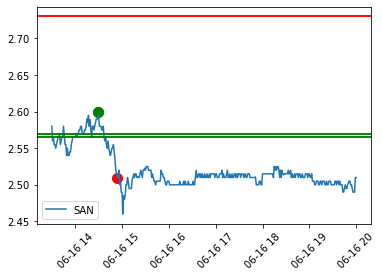

GOL analysis for run 1510 with profit -99.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3210.24,-3210.24,buy,2020-06-16 14:16:38.628333,8.36,"[8.02, 8.03, 8.04, 8.1873]","[8.375, 8.65, 8.69]",384,"{'avg': 8.1795, 'rsi': 68.15387235562731, 'macd': [0.03718283113188825, 0.03605295482929094, 0.033161422628346315, 0.04009071879423409, 0.04825366343936821], 'vwap': 8.3679, 'supports': [8.02, 8.04, 8.1873], 'sell_macd': [0.017743453518164642, 0.017218471677880487, 0.015546817364958443, 0.020276089103395734, 0.025775832157979295], 'slow macd': [0.0864182773294857, 0.08552164535303852, 0.08424006328217892, 0.08484546888066902, 0.08590650702805114], 'macd_signal': [0.057511348454084135, 0.05321966972912549, 0.04920802030896966, 0.04738456000602255, 0.04755838069269168], 'resistances': [8.61], 'position_ratio': '1.31', 'sell_macd_signal': [0.030515023759198928, 0.02785571334293524, 0.02539393414733988, 0.02437036513855105, 0.0246514585424367]}",8.89,8.11
1,-1258.14,1952.10,sell,2020-06-16 14:32:48.972949,8.10,None,None,241,"{'avg': 8.1831, 'rsi': [44.48404482903735, 39.34602593735229], 'vwap': 8.1115, 'reasons': 'stopped', 'movement': -0.029904306220095697, 'sell_macd': [-0.0042478197660589245, -0.006076804940516212, -0.006903588129176796, -0.007977658300481139, -0.010788912222270852], 'sell_macd_signal': [0.002155669819310842, 0.0005091748673454312, -0.0009733777319590143, -0.0023742338456634393, -0.004057169520984922]}",8.89,8.11
2,-99.84,1158.30,sell,2020-06-16 14:32:49.160158,8.10,None,None,143,"{'avg': 8.1831, 'rsi': [44.48404482903735, 39.34602593735229], 'vwap': 8.1115, 'reasons': 'stopped', 'movement': -0.029904306220095697, 'sell_macd': [-0.0042478197660589245, -0.006076804940516212, -0.006903588129176796, -0.007977658300481139, -0.010788912222270852], 'sell_macd_signal': [0.002155669819310842, 0.0005091748673454312, -0.0009733777319590143, -0.0023742338456634393, -0.004057169520984922]}",8.89,8.11


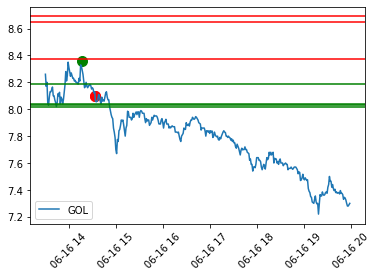

PE analysis for run 1510 with profit -99.54


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2817.93,-2817.93,buy,2020-06-16 14:12:37.038155,11.89,"[11.555, 11.565, 11.57, 11.6102, 11.65, 11.74]","[12.175, 12.19, 12.205, 12.205]",237,"{'avg': 11.6999, 'rsi': 69.78551541962858, 'macd': [0.08778968366206641, 0.08369206209374447, 0.08112336072718129, 0.08337154785335521, 0.08378398451513291], 'vwap': 11.89, 'supports': [11.0413, 11.055, 11.08, 11.555, 11.565], 'sell_macd': [0.050760204845778034, 0.0480655855720844, 0.046380614896841976, 0.047841928462927896, 0.04809955035256763], 'slow macd': [0.08548948434610715, 0.08580781996113274, 0.08628333334391058, 0.08762240689864598, 0.08863428959430841], 'macd_signal': [0.08145835948375393, 0.08190510000575205, 0.08174875215003789, 0.08207331129070136, 0.08241544593558767], 'resistances': [12.19, 12.205, 12.205], 'position_ratio': '0.92', 'sell_macd_signal': [0.04659814476984521, 0.046891632930293047, 0.04678942932360283, 0.04699992915146785, 0.047219853391687806]}",12.73,11.47
1,-99.54,2718.39,sell,2020-06-16 14:57:33.937270,11.47,None,None,237,"{'avg': 11.714, 'rsi': [29.494840225147524, 26.74618826207198], 'vwap': 11.465, 'reasons': 'stopped', 'movement': -0.035744322960471045, 'sell_macd': [-0.01620744307409261, -0.01954444144227807, -0.025527239632522125, -0.030117377967355807, -0.035380896436482345], 'sell_macd_signal': [-0.01597519399474063, -0.016689043484248118, -0.018456682713902918, -0.020788821764593495, -0.023707236698971266]}",12.73,11.47


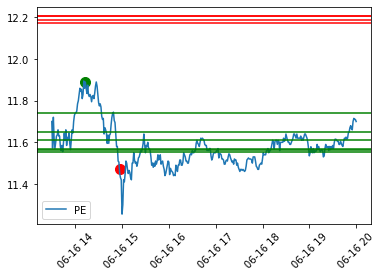

SOLO analysis for run 1510 with profit -112.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1121.28,-1121.28,buy,2020-06-16 13:58:26.147741,2.19,"[2.08, 2.13]","[2.5488, 2.585, 2.61, 2.6353, 2.7]",512,"{'avg': 2.1449, 'rsi': 69.6442847177955, 'macd': [0.019748694220059537, 0.022379127591368952, 0.025748508408304893, 0.028892627186151376, 0.030627847001431174], 'vwap': 2.1925, 'supports': [2.08], 'sell_macd': [0.01132322442663991, 0.01303725594364158, 0.015221731723855214, 0.017245716335400285, 0.018339136599780925], 'slow macd': [0.017536835386304794, 0.01837162161696515, 0.019423743420356576, 0.02052059959625474, 0.021416954519228426], 'macd_signal': [0.01755498206892494, 0.018519811173413742, 0.019965550620391972, 0.021750965933543854, 0.023526342147121317], 'resistances': [2.5488], 'position_ratio': '3.08', 'sell_macd_signal': [0.009899906579378177, 0.010527376452230858, 0.01146624750655573, 0.012622141272324642, 0.013765540337815898]}",2.58,2.0
1,-112.64,1008.64,sell,2020-06-16 14:56:34.723726,1.97,None,None,512,"{'avg': 2.1298, 'rsi': [26.368430672857368, 21.19106558909544], 'vwap': 1.9788, 'reasons': 'stopped', 'movement': -0.1004566210045662, 'sell_macd': [-0.009733347530726633, -0.01021440139365426, -0.012534516073940072, -0.014699092239436329, -0.01827279974190832], 'sell_macd_signal': [-0.009900887169181838, -0.009963590014076321, -0.010477775226049072, -0.011322038628726524, -0.012712190851362883]}",2.58,2.0


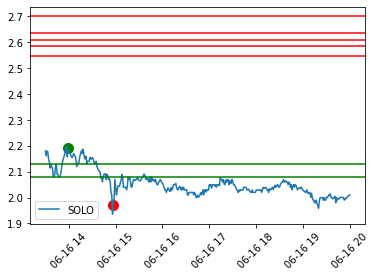

XERS analysis for run 1514 with profit -105.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1321.32,-1321.32,buy,2020-06-16 14:17:39.424044,4.84,"[4.41, 4.46, 4.5, 4.51, 4.7]","[5.03, 5.07, 5.09]",273,"{'avg': 4.6837, 'rsi': 65.91302574274613, 'macd': [0.04031315330254426, 0.037752064859577494, 0.0361130119215316, 0.036810471734497696, 0.04092602604112905], 'vwap': 4.835, 'supports': [4.3341, 4.35, 4.41, 4.46, 4.46, 4.48, 4.5, 4.7], 'sell_macd': [0.022592548983097593, 0.020947912610022712, 0.019913807480222978, 0.020407831957260036, 0.023125151913947484], 'slow macd': [0.044539402362643976, 0.04444709151149162, 0.04445101168960175, 0.044863333274197004, 0.04597060981680201], 'macd_signal': [0.04286791546689013, 0.041844745345427606, 0.04069839866064841, 0.039920813275418264, 0.04012185582856042], 'resistances': [5.03, 5.07, 5.09], 'position_ratio': '1.36', 'sell_macd_signal': [0.024288455213765752, 0.023620346693017144, 0.022879038850458312, 0.02238479747181866, 0.022532868360244422]}",5.22,4.65
1,-2541.00,-1219.68,buy,2020-06-16 14:17:39.629904,4.84,"[4.41, 4.46, 4.5, 4.51, 4.7]","[5.03, 5.07, 5.09]",252,"{'avg': 4.6837, 'rsi': 65.91302574274613, 'macd': [0.04031315330254426, 0.037752064859577494, 0.0361130119215316, 0.036810471734497696, 0.04092602604112905], 'vwap': 4.835, 'supports': [4.3341, 4.35, 4.41, 4.46, 4.46, 4.48, 4.5, 4.7], 'sell_macd': [0.022592548983097593, 0.020947912610022712, 0.019913807480222978, 0.020407831957260036, 0.023125151913947484], 'slow macd': [0.044539402362643976, 0.04444709151149162, 0.04445101168960175, 0.044863333274197004, 0.04597060981680201], 'macd_signal': [0.04286791546689013, 0.041844745345427606, 0.04069839866064841, 0.039920813275418264, 0.04012185582856042], 'resistances': [5.03, 5.07, 5.09], 'position_ratio': '1.36', 'sell_macd_signal': [0.024288455213765752, 0.023620346693017144, 0.022879038850458312, 0.02238479747181866, 0.022532868360244422]}",5.22,4.65
2,-105.00,2436.00,sell,2020-06-16 14:44:03.936741,4.64,None,None,525,"{'avg': 4.7042, 'rsi': [40.20962557485993, 36.8740505873337], 'vwap': 4.65, 'reasons': 'stopped', 'movement': -0.039256198347107335, 'sell_macd': [0.004921062548808308, 0.0017343311250019866, -0.0028492820769896454, -0.006383925064554319, -0.010613725768312321], 'sell_macd_signal': [0.015119628371420677, 0.012442568922136939, 0.009384198722311622, 0.006230573964938433, 0.002861714018288282]}",5.22,4.65


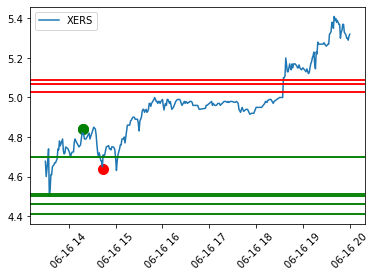

HEES analysis for run 1514 with profit 40.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3024.84,-3024.84,buy,2020-06-16 14:17:18.543264,19.39,"[18.8, 18.948]","[20.14, 20.23, 20.23]",156,"{'avg': 19.1055, 'rsi': 68.87037407788105, 'macd': [0.12937797730318223, 0.1319629127735169, 0.1364729002471563, 0.1424397234786703, 0.15027766505916063], 'vwap': 19.3996, 'supports': [17.68, 17.85, 17.85, 18.82, 18.93, 18.948], 'sell_macd': [0.07101285077305164, 0.07291289457815964, 0.07604393008112709, 0.08009351709537427, 0.08532574701432694], 'slow macd': [0.1669561191470983, 0.16825677108385406, 0.16998398940538095, 0.1721009000012259, 0.17473289027753225], 'macd_signal': [0.1330270900670455, 0.1328142546083398, 0.1335459837361031, 0.13532473168461653, 0.13831531835952535], 'resistances': [20.02], 'position_ratio': '1.32', 'sell_macd_signal': [0.07252831248155134, 0.072605228900873, 0.07329296913692382, 0.0746530787286139, 0.07678761238575652]}",20.69,18.77
1,40.56,3065.40,sell,2020-06-16 14:29:41.047631,19.65,None,None,156,"{'avg': 19.265, 'rsi': [73.95312405252959, 79.88260430343489], 'vwap': 19.7245, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.01856627127385247, 'sell_macd': [0.06732800506086534, 0.07489715737828817, 0.07982250778954736, 0.08262378722962538, 0.09360369605008145], 'sell_macd_signal': [0.06854342207921524, 0.06981416913902982, 0.07181583686913333, 0.07397742694123174, 0.07790268076300169]}",20.69,18.77


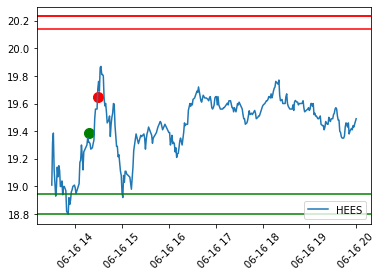

PRA analysis for run 1514 with profit 9.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3517.12,-3517.12,buy,2020-06-16 14:17:50.792157,15.16,"[14.78, 14.79, 15.01]","[15.44, 15.44]",232,"{'avg': 14.8859, 'rsi': 69.77093881789246, 'macd': [0.11116871330307454, 0.10711372421351051, 0.1043115108332131, 0.10651135492747521, 0.11180739967451814], 'vwap': 15.16, 'supports': [13.75, 13.91, 14.06, 14.78, 15.01], 'sell_macd': [0.06171459993305639, 0.0591953954870057, 0.057502568704535406, 0.059073059929826144, 0.06264651984654712], 'slow macd': [0.14220878014564953, 0.1420341442775097, 0.1419661819785496, 0.1427961515995726, 0.1442909838632982], 'macd_signal': [0.1157221283742376, 0.11400044754209218, 0.11206266020031637, 0.11095239914574814, 0.11112339925150214], 'resistances': [15.36, 15.44, 15.44, 15.44], 'position_ratio': '1.33', 'sell_macd_signal': [0.06437980643528697, 0.06334292424563072, 0.062174853137411654, 0.06155449449589455, 0.061772899566025066]}",16.02,14.73
1,9.28,3526.40,sell,2020-06-16 14:28:09.164663,15.20,None,None,232,"{'avg': 14.9204, 'rsi': [66.16159127715923, 66.16159127715923], 'vwap': 15.22, 'reasons': 'bail', 'movement': 0.003957783641160982, 'sell_macd': [0.050306223373489445, 0.04990225511875046, 0.05363549732130757, 0.054289510760687776, 0.054094073041232704], 'sell_macd_signal': [0.05538468824521044, 0.054288201619918444, 0.05415766076019627, 0.05418403076029457, 0.0541660392164822]}",16.02,14.73


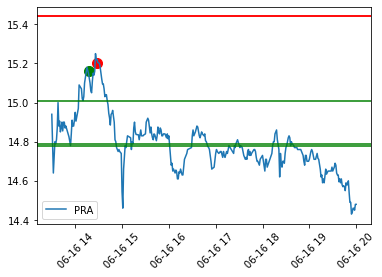

KOP analysis for run 1515 with profit -104.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4786.74,-4786.74,buy,2020-06-16 14:39:52.444019,18.34,"[16.93, 17.81, 17.89, 18.02, 18.14]","[19.12, 19.155, 19.21]",261,"{'avg': 17.9375, 'rsi': 67.8350245364143, 'macd': [0.06855077921593633, 0.0728787827828512, 0.07543914132920193, 0.07698427533184926, 0.08330044270906001], 'vwap': 18.3368, 'supports': [16.72, 16.76, 16.81, 16.81, 16.82, 16.93, 17.81, 17.89, 18.02, 18.14], 'sell_macd': [0.03547530697769474, 0.038548686620885064, 0.040442895607515794, 0.04165341045933957, 0.045951819298952756], 'slow macd': [0.14912230265305126, 0.1488405906303356, 0.14834335683314137, 0.1477285993782509, 0.14812625179679628], 'macd_signal': [0.08273868570118247, 0.08076670511751621, 0.07970119235985336, 0.07915780895425253, 0.07998633570521403], 'resistances': [19.12, 19.155], 'position_ratio': '3.67', 'sell_macd_signal': [0.043706415172601334, 0.04267486946225808, 0.04222847469130962, 0.042113461844915615, 0.04288113333572304]}",19.11,17.97
1,-2580.12,2206.62,sell,2020-06-16 14:43:54.154223,17.94,None,None,123,"{'avg': 17.9399, 'rsi': [43.023776528224296, 39.67272422866604], 'vwap': 17.94, 'reasons': 'stopped', 'movement': -0.02181025081788433, 'sell_macd': [0.04165341045933957, 0.045951819298952756, 0.03883432204021986, 0.02499167064328134, 0.010244258247706028], 'sell_macd_signal': [0.042113461844915615, 0.04288113333572304, 0.042071771076622404, 0.03865575098995419, 0.032973452441504555]}",19.11,17.97
2,-1001.40,1578.72,sell,2020-06-16 14:43:54.350789,17.94,None,None,88,"{'avg': 17.9399, 'rsi': [43.023776528224296, 39.67272422866604], 'vwap': 17.94, 'reasons': 'stopped', 'movement': -0.02181025081788433, 'sell_macd': [0.04165341045933957, 0.045951819298952756, 0.03883432204021986, 0.02499167064328134, 0.010244258247706028], 'sell_macd_signal': [0.042113461844915615, 0.04288113333572304, 0.042071771076622404, 0.03865575098995419, 0.032973452441504555]}",19.11,17.97
3,-104.40,897.00,sell,2020-06-16 14:43:56.118731,17.94,None,None,50,"{'avg': 17.9399, 'rsi': [43.023776528224296, 39.67272422866604], 'vwap': 17.94, 'reasons': 'stopped', 'movement': -0.02181025081788433, 'sell_macd': [0.04165341045933957, 0.045951819298952756, 0.03883432204021986, 0.02499167064328134, 0.010244258247706028], 'sell_macd_signal': [0.042113461844915615, 0.04288113333572304, 0.042071771076622404, 0.03865575098995419, 0.032973452441504555]}",19.11,17.97


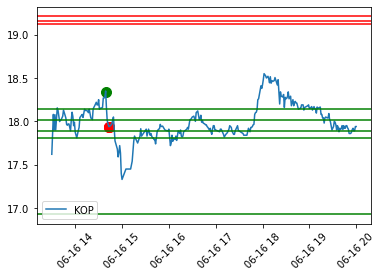

DCP analysis for run 1518 with profit -1409.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1409.64,-1409.64,buy,2020-06-16 17:17:54.742224,13.82,[13.65],"[13.82, 13.85]",102,"{'avg': 13.6777, 'rsi': 69.98088279607327, 'macd': [0.10819236481314043, 0.11024921756971295, 0.11539063534116245, 0.11730609786476265, 0.12464948191755809], 'vwap': 13.8547, 'supports': [12.63, 12.78, 12.81, 12.93, 13.46], 'sell_macd': [0.05971061147520196, 0.06112166253103268, 0.06454427812608188, 0.06585353341928801, 0.07069381633062655], 'slow macd': [0.10521045774784277, 0.10723129740560822, 0.10987864921004409, 0.1119786259814024, 0.11517100184984308], 'macd_signal': [0.13159244679281185, 0.12732380094819207, 0.12493716782678614, 0.12341095383438144, 0.12365865945101677], 'resistances': [14.53, 14.6, 14.6, 14.72], 'position_ratio': '1.61', 'sell_macd_signal': [0.07560231330072997, 0.07270618314679052, 0.07107380214264879, 0.07002974839797663, 0.07016256198450661]}",14.85,13.38


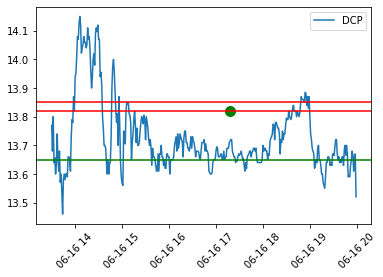

In [14]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))

In [ ]:
for batch_id, count in batch.items():
    for run_id in batch[batch_id]:
        for symbol in minute_history:    
            if symbol not in trade_details[run_id]:
                continue
            start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
            minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
            plt.plot(minute_history[symbol]["close"][minute_history_index:].between_time("9:30", "16:00"), label=symbol)
            plt.xticks(rotation=45)
            delta = 0
            profit = 0

            operations = []
            deltas = []
            profits = []
            times = []
            prices = []
            qtys = []
            indicators = []
            target_price = []
            stop_price = []
            resistances = []
            supports = []
            for trade in trade_details[run_id][symbol]:
                resistance = None
                support = None
                if trade[0] == 'buy':
                    resistance = find_resistance(trade[2], minute_history[symbol], trade[1])

                    for r in resistance:
                        plt.axhline(y=r, color="r")
                    support = find_support(trade[2], minute_history[symbol], trade[1])
                    for s in support:
                        plt.axhline(y=s, color="g")  

                delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
                profit += delta
                plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
                deltas.append(round(delta, 2))
                profits.append(round(profit, 2))
                operations.append(trade[0])
                times.append(pd.to_datetime(trade[1]))
                prices.append(trade[2])
                qtys.append(trade[3])
                indicators.append(trade[4])
                target_price.append(trade[6])
                stop_price.append(trade[5])    
                resistances.append(resistance)
                supports.append(support)
            d = {
                'profit': profits,
                'trade': deltas,
                'operation': operations,
                'at': times,
                'price': prices,
                'support': supports,
                'resistance': resistances,
                'qty': qtys,
                'indicators': indicators,
                'target price': target_price,
                'stop price': stop_price
            }   
            print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
            display(HTML(pd.DataFrame(data=d).to_html()))
            plt.legend()
            plt.show()

In [15]:
minute_history['PERI']

,open,high,low,close,volume
timestamp,,,,,
2020-06-08 07:06:00-04:00,5.7500,5.7500,5.75,5.75,1000
2020-06-08 07:16:00-04:00,5.7500,5.7500,5.75,5.75,180
2020-06-08 09:21:00-04:00,5.8200,5.8200,5.82,5.82,1000
2020-06-08 09:30:00-04:00,5.8400,5.8600,5.80,5.80,22488
2020-06-08 09:31:00-04:00,5.8300,5.8600,5.83,5.86,1662
...,...,...,...,...,...
2020-06-16 15:55:00-04:00,5.6100,5.6200,5.61,5.62,248
2020-06-16 15:57:00-04:00,5.6089,5.6089,5.60,5.60,2503
2020-06-16 15:58:00-04:00,5.6000,5.6000,5.60,5.60,317
